# Change-point Kernel Decoder-only transformer experiments

This notebook contains experiments of Change-point Kernel attention decoder-only transformer applied in the context of timeseries forecasting. In this notebook, you will find the following experiments:
- **Experiment 1**: 1-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 2**: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target
- **Experiment 3**: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target
- **Experiment 4**: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series
- **Experiment 5**: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target
- **Experiment 6**: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target
- **Experiment 7**: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

For visualization and inspection purposes, we use 3 decoder layers and a single attention head

In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
plt.rcParams["pdf.use14corefonts"] = True

import src.Datasets.SyntheticDataset as SD
from src.Transformer.DecoderOnly import PointDecoderOnlyTransformer
from src.Transformer.KernelAttention import ChangePointKernelAttention
from src.train import train_step_dec_only, val_step_dec_only
from src.utils import collate_fn, EarlyStopping

ES = EarlyStopping(patience=30, delta=0)

In [2]:
# configs
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# attention module
_attention = ChangePointKernelAttention(period=20, p_norm=2)

# meta data to store images
FOLDER = "CP_kernel"
KERNEL_NAME = "CP"

# transformer configs
n_heads = 1                             # number of attention heads in multi-head attention
n_layers = 3                            # number of decoder blocks
emb_size = 64                           # size of transformer block embedding (d_model)
n_hidden = emb_size // n_heads          # Query, Key, Value projection dimension (self-attention)
ffn_n_hidden = emb_size * 4             # point-wise feed forward net hidden dimensions

# train configs
ps = [0.5, 0.9]                         # rho_quantile loss probs
lr = 0.0005                             # initial learning rate
lr_step_size = 10                       # every n steps decrease learning rate by gamma
lr_gamma = 0.95                         # learning rate decrease rate
EPOCHS = 300                            # training epochs

## Experiment 1: one-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [3]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 1                               # number of steps to predict at once  
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

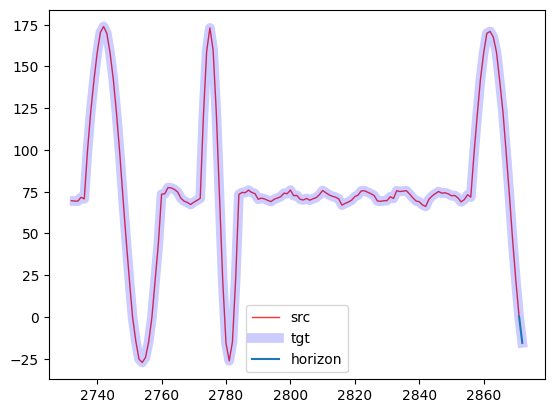

In [4]:
src_X, src_fX, tgt_X, tgt_fX = train_set[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [5]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [6]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]
    
    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2071.9646	val_loss=1510.7791	train_mape_loss=20.2435	val_mape_loss=27.1641	R_p=['0.2808', '0.2590']
epoch=1	train_loss=1518.4784	val_loss=1507.5584	train_mape_loss=22.9869	val_mape_loss=27.0375	R_p=['0.2764', '0.2599']
epoch=2	train_loss=1516.6031	val_loss=1507.2998	train_mape_loss=22.6753	val_mape_loss=27.0887	R_p=['0.2760', '0.2599']
epoch=3	train_loss=1515.7173	val_loss=1508.4129	train_mape_loss=23.0171	val_mape_loss=27.2749	R_p=['0.2777', '0.2571']
epoch=4	train_loss=1513.5759	val_loss=1506.6159	train_mape_loss=23.0545	val_mape_loss=27.4518	R_p=['0.2792', '0.2556']
epoch=5	train_loss=1506.5686	val_loss=1462.3910	train_mape_loss=22.8287	val_mape_loss=26.5884	R_p=['0.2733', '0.2654']
epoch=6	train_loss=1435.8209	val_loss=972.7550	train_mape_loss=19.6612	val_mape_loss=11.5747	R_p=['0.2840', '0.2174']
epoch=7	train_loss=603.1180	val_loss=235.7862	train_mape_loss=5.8514	val_mape_loss=4.4806	R_p=['0.1196', '0.1133']
epoch=8	train_loss=262.4811	val_loss=178.3601	train_m

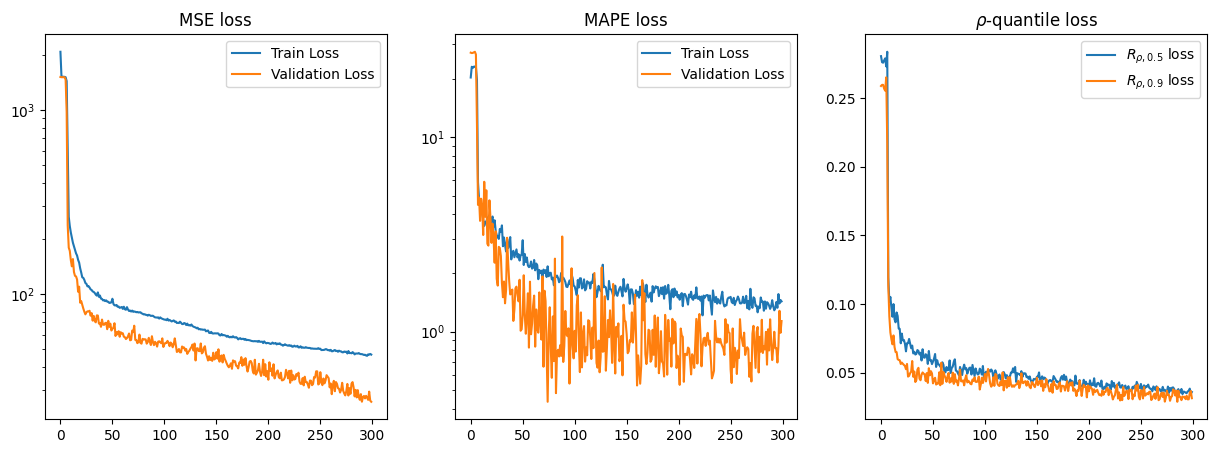

In [7]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [8]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(25.69225881958008,
 0.9598173885345459,
 [0.03545529395341873, 0.031379248946905136])

In [9]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [10]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(25.664495635986327,
 0.9483283405303955,
 tensor([0.0355, 0.0314], device='cuda:0'))

### Predict

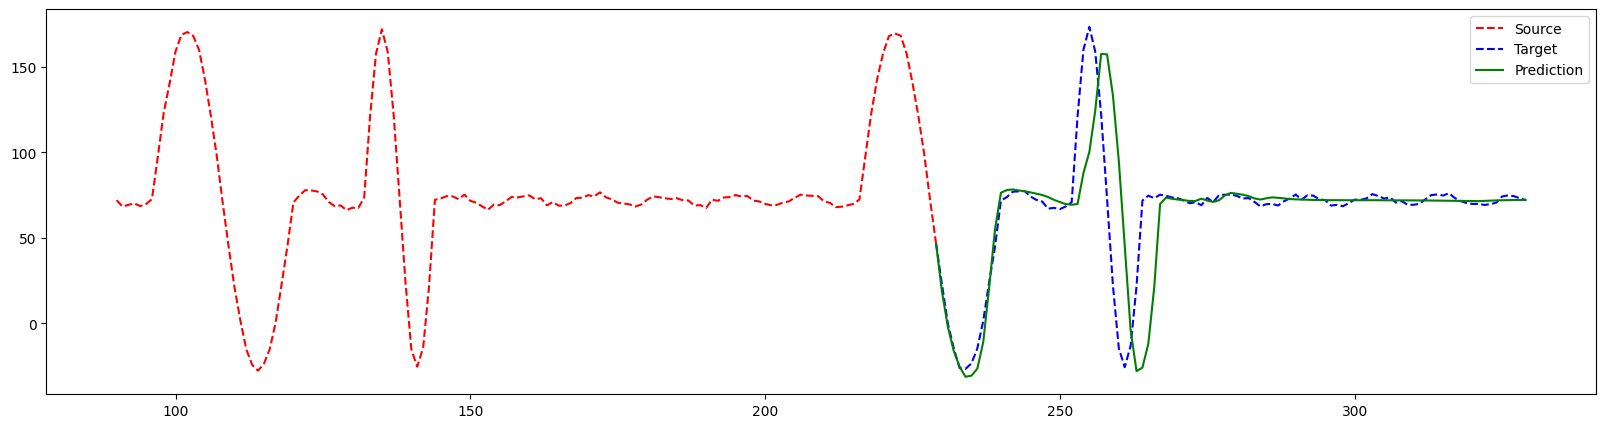

In [11]:
idx = 90
mask = dataset.mask
shift = dataset.shift
horizon = 100

tgt_X, tgt_fX = [], []
_, _, tgt_x, tgt_fx = dataset[idx-1]
tgt_X.append(tgt_x[-1].squeeze().item())
tgt_fX.append(tgt_fx[-1].squeeze().item())

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, _, _ = (v.unsqueeze(0).to(device) for v in sample)
    pred_X = torch.clone(src_X)
    pred_fX = torch.clone(src_fX)
    mask = mask.to(device)
        
    for step in range(horizon):
        
        out = model(pred_X[:, -seq_len:], pred_fX[:, -seq_len:], mask)
        pred_fX = torch.cat([pred_fX, out[:, -shift:]], dim=1)
        pred_X = torch.cat([pred_X, pred_X[:, -1:] + 1], dim=1)
        
        attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])
        
        _, _, tgt_x, tgt_fx = dataset[idx+step]
        tgt_X.append(tgt_x[-1].squeeze().item())
        tgt_fX.append(tgt_fx[-1].squeeze().item())

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label="Prediction")
plt.legend()

In [12]:
inspect_step = 0

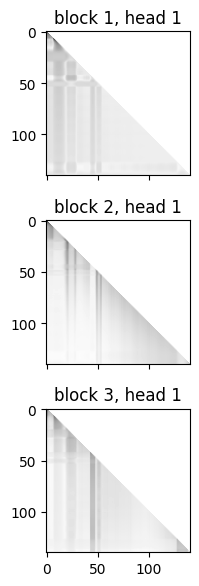

In [13]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

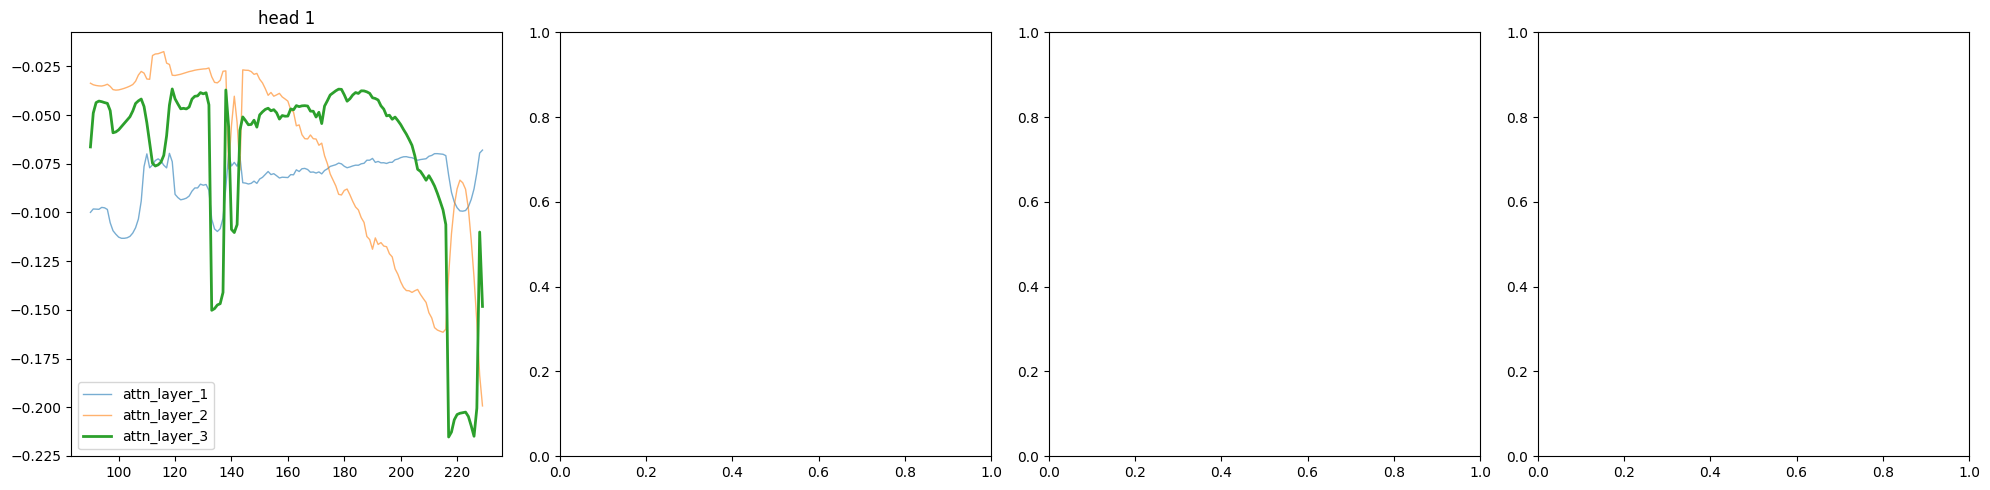

In [14]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -1, :].cpu() # index (inspect_step, attn_layer_i, sample_0, head_j, last row, :)
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

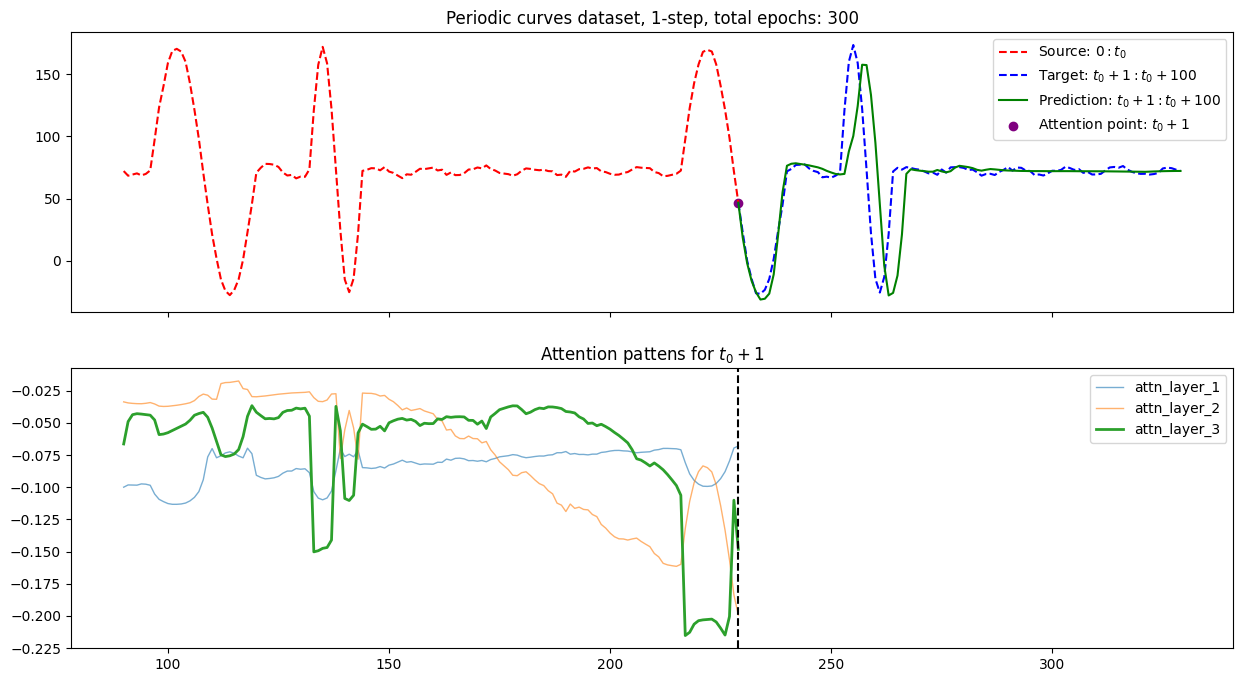

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{horizon}$")
ax1.plot(pred_X.squeeze()[-horizon-1:].cpu(), pred_fX.squeeze()[-horizon-1:].cpu(), '-g', label=f"Prediction: $t_0+1: t_0+{horizon}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, 1-step, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_1pred_at_once.pdf", dpi=1200)

## Experiment 2: $n$-step prediction on `SimplePeriodicDataset` with overlapping source and target

In [16]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100)

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

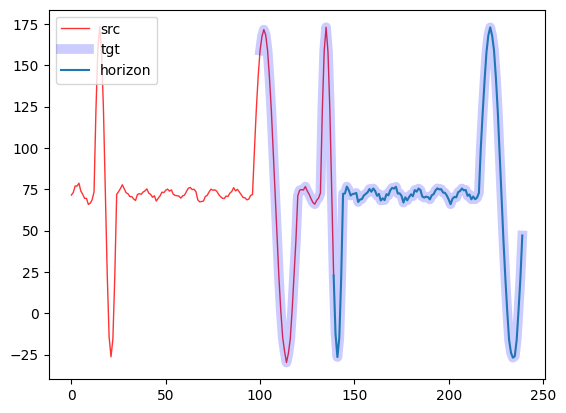

In [17]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [18]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [19]:
for epoch in range(EPOCHS):
    
    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, 0, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, 0, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2149.5294	val_loss=1510.2267	train_mape_loss=6.2732	val_mape_loss=5.8997	R_p=['0.2813', '0.2587']
epoch=1	train_loss=1516.7050	val_loss=1508.3442	train_mape_loss=7.0862	val_mape_loss=5.8861	R_p=['0.2789', '0.2572']
epoch=2	train_loss=1514.7896	val_loss=1506.3070	train_mape_loss=7.1243	val_mape_loss=5.8442	R_p=['0.2764', '0.2604']
epoch=3	train_loss=1513.8491	val_loss=1504.5970	train_mape_loss=7.0938	val_mape_loss=5.6914	R_p=['0.2745', '0.2799']
epoch=4	train_loss=1512.8160	val_loss=1506.0859	train_mape_loss=7.0734	val_mape_loss=5.8385	R_p=['0.2762', '0.2608']
epoch=5	train_loss=1512.6506	val_loss=1506.1506	train_mape_loss=7.0615	val_mape_loss=5.8402	R_p=['0.2762', '0.2606']
epoch=6	train_loss=1512.1923	val_loss=1504.2514	train_mape_loss=7.0890	val_mape_loss=5.7644	R_p=['0.2741', '0.2691']
epoch=7	train_loss=1511.4284	val_loss=1504.2261	train_mape_loss=7.0688	val_mape_loss=5.7607	R_p=['0.2741', '0.2692']
epoch=8	train_loss=1511.5361	val_loss=1506.3315	train_mape_loss=

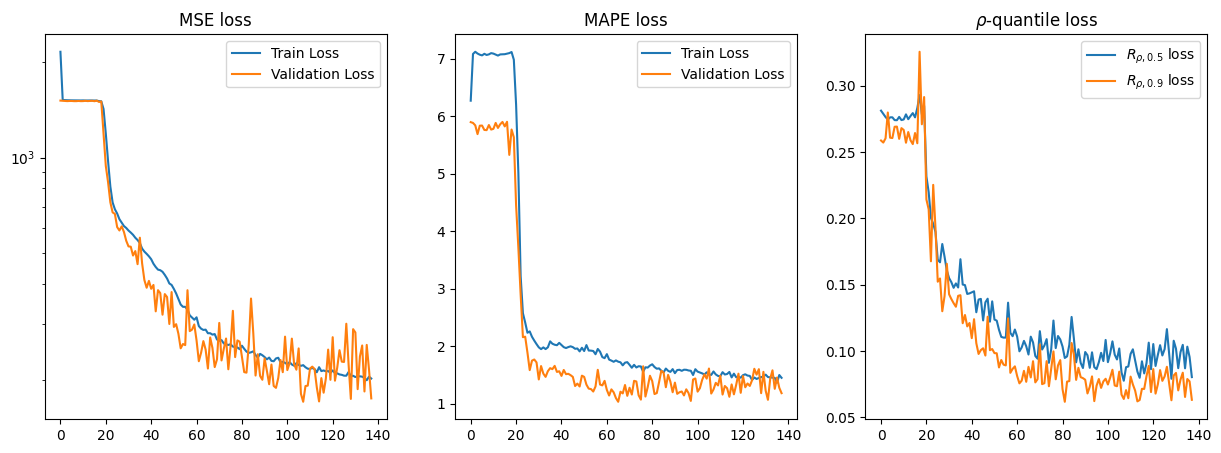

In [20]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [21]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, 0, device)

test_loss, test_mape_loss, r_ps.tolist()

(182.90489331054687,
 1.3329512844085694,
 [0.08168106526136398, 0.06501079350709915])

In [22]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pth"
torch.save(best_model.state_dict(), path)

In [23]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, 0, device)

best_test_loss, best_test_mape_loss, best_r_ps

(182.9916202392578,
 1.4127114152908324,
 tensor([0.0799, 0.0665], device='cuda:0'))

### Predict

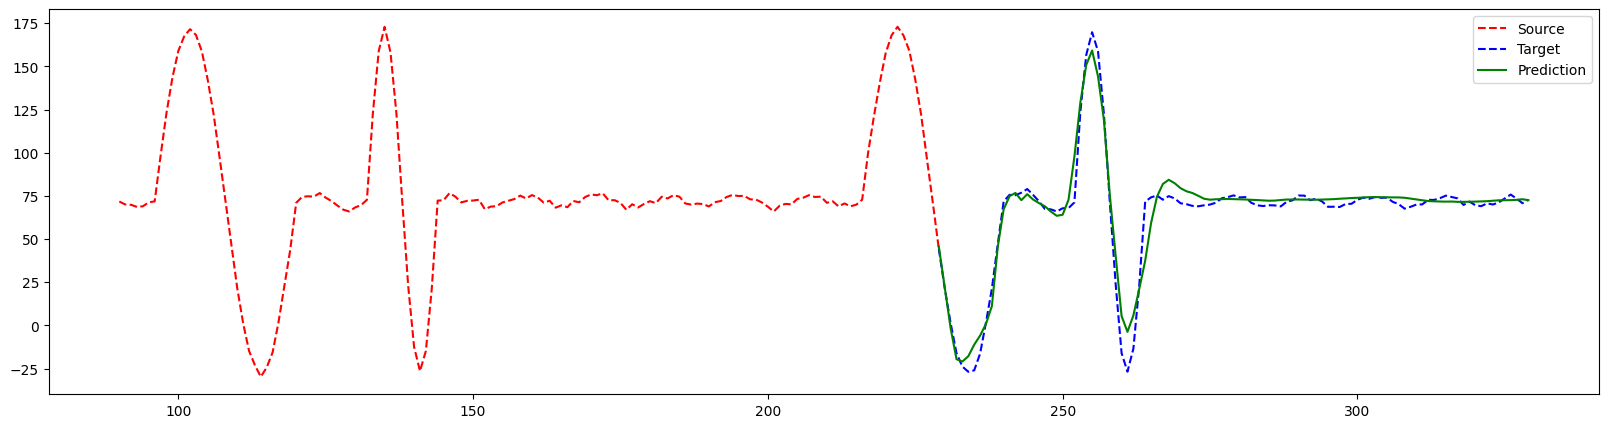

In [24]:
idx = 90
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift-1:].squeeze().cpu()
    
    tgt_X = tgt_X[:, -shift-1:].squeeze().cpu()
    tgt_fX = tgt_fX[:, -shift-1:].squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [25]:
inspect_step = 0

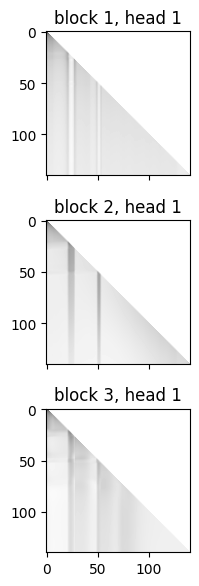

In [26]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

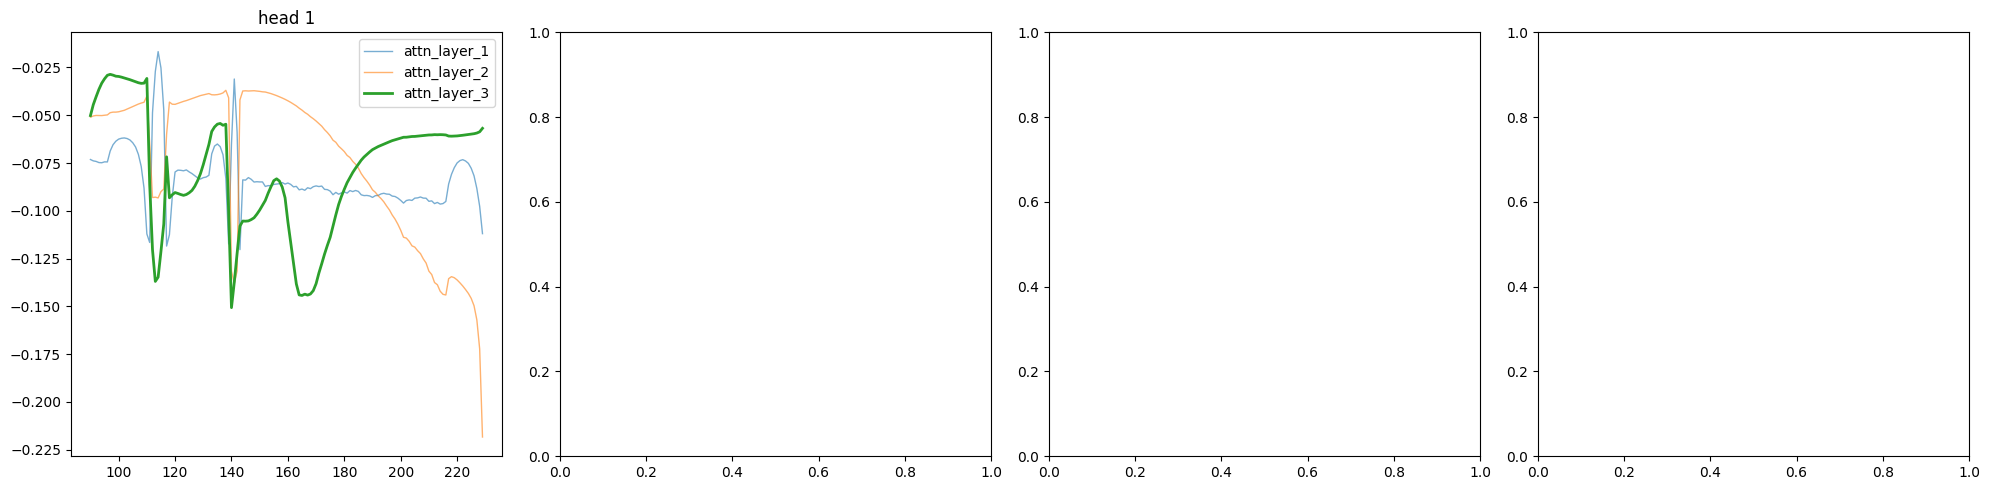

In [27]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

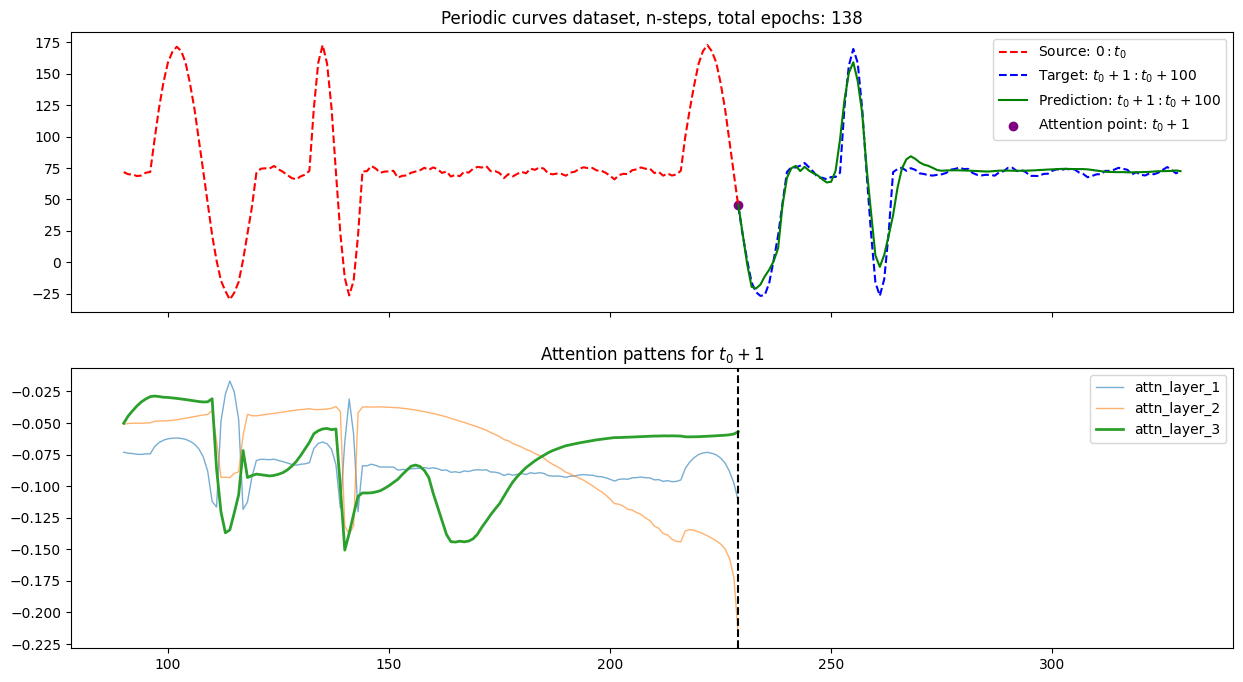

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(pred_X.squeeze()[-horizon-1+inspect_step].cpu(), pred_fX.squeeze()[-horizon-1+inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu()+inspect_step, attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
    ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")

ax2.axvline(src_X.squeeze().cpu()[-1]+inspect_step, linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once.pdf", dpi=1200)

## Experiment 3: $n$-step prediction on `SimplePeriodicDataset` with non-overlapping source and target

In [29]:
DATASET_NAME = "simple_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SimplePeriodicDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, A1=5, A2=100, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

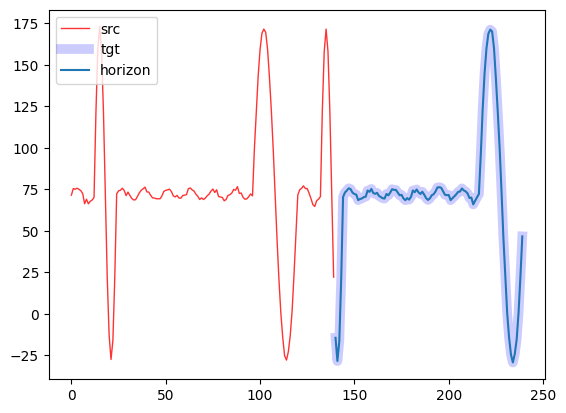

In [30]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

### Training setup

In [31]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [32]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1969.4547	val_loss=1522.8293	train_mape_loss=4.1017	val_mape_loss=4.6887	R_p=['0.2776', '0.2722']
epoch=1	train_loss=1523.6967	val_loss=1529.1247	train_mape_loss=4.4844	val_mape_loss=4.8367	R_p=['0.2853', '0.2565']
epoch=2	train_loss=1518.7693	val_loss=1522.4467	train_mape_loss=4.4671	val_mape_loss=4.6062	R_p=['0.2774', '0.2875']
epoch=3	train_loss=1517.0560	val_loss=1521.6367	train_mape_loss=4.4598	val_mape_loss=4.7043	R_p=['0.2766', '0.2703']
epoch=4	train_loss=1516.9237	val_loss=1522.8944	train_mape_loss=4.4707	val_mape_loss=4.7462	R_p=['0.2783', '0.2645']
epoch=5	train_loss=1515.5316	val_loss=1532.1178	train_mape_loss=4.4705	val_mape_loss=4.8694	R_p=['0.2890', '0.2550']
epoch=6	train_loss=1515.3614	val_loss=1523.0592	train_mape_loss=4.4600	val_mape_loss=4.7502	R_p=['0.2786', '0.2639']
epoch=7	train_loss=1514.4302	val_loss=1521.6515	train_mape_loss=4.4767	val_mape_loss=4.7035	R_p=['0.2766', '0.2695']
epoch=8	train_loss=1514.1083	val_loss=1521.3639	train_mape_loss=

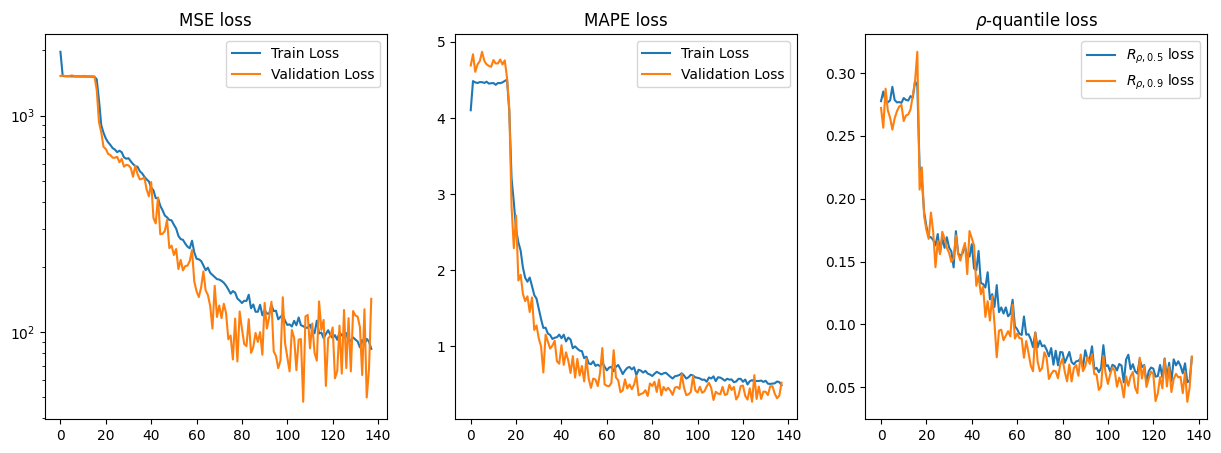

In [33]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [34]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(144.1581094970703,
 0.5993452930450439,
 [0.07458960264921188, 0.07471395283937454])

In [35]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [36]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(45.809465576171874,
 0.39973866510391237,
 tensor([0.0535, 0.0413], device='cuda:0'))

### Predict

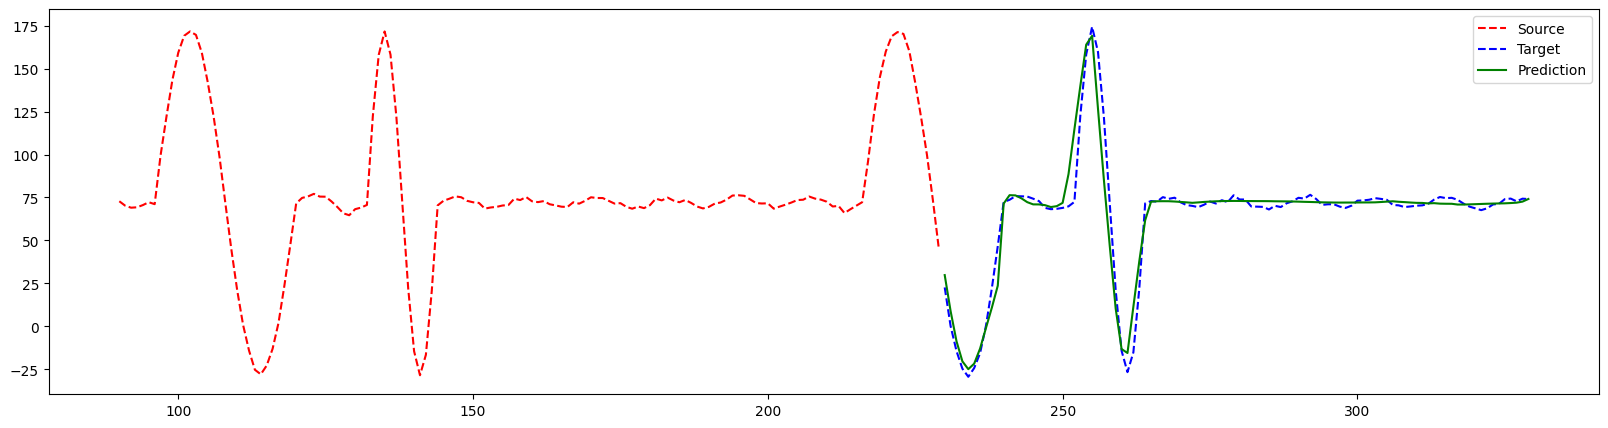

In [37]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [38]:
inspect_step = 0

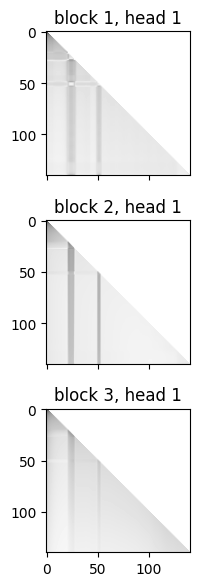

In [39]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

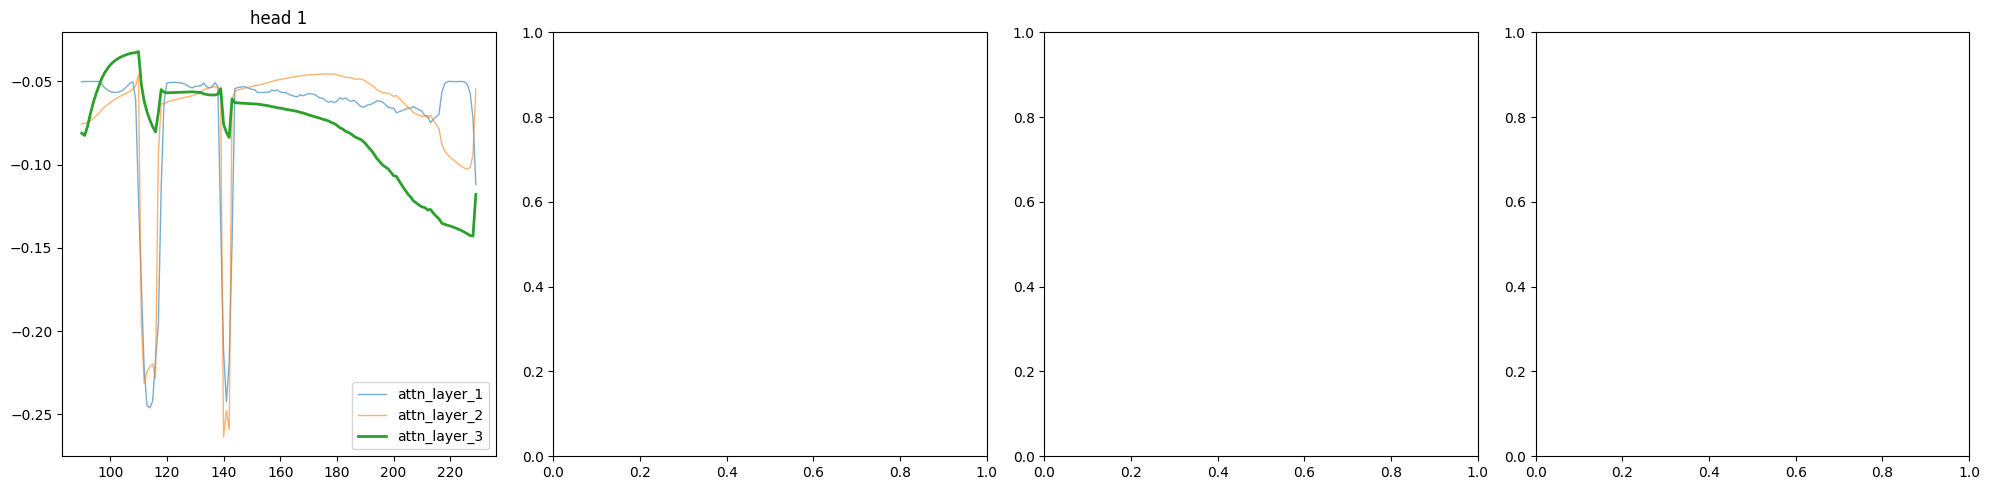

In [40]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

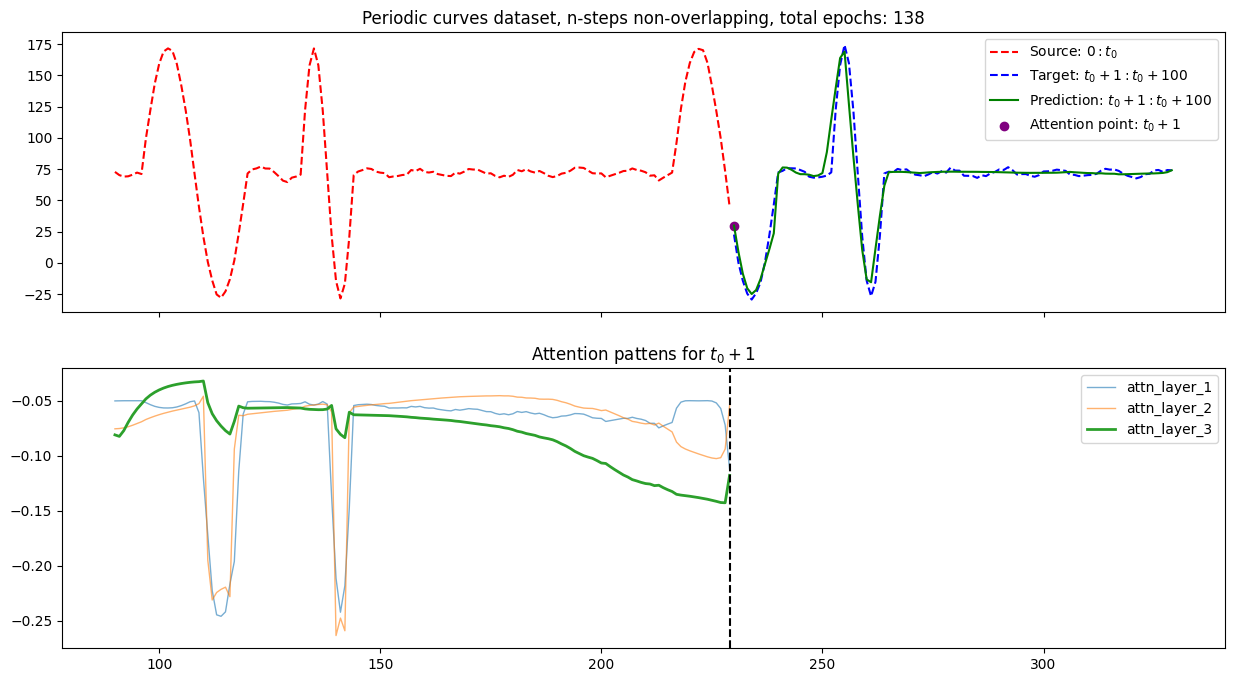

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Periodic curves dataset, n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 4: $n$-step prediction on `MultivarPeriodicDataset` with non-overlapping source and target and $m$ time series

In [42]:
DATASET_NAME = "multivar_periodic_curves"

seq_len = 140                           # sequence length of each sample
n_timeseries = 100                      # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultivarPeriodicDataset(len_timeseries=total_length, n_timeseries=n_timeseries, seq_len=seq_len, shift=shift, mode='nonoverlapping')

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

(torch.Size([140, 1]),
 torch.Size([140, 100]),
 torch.Size([100, 1]),
 torch.Size([100, 100]))

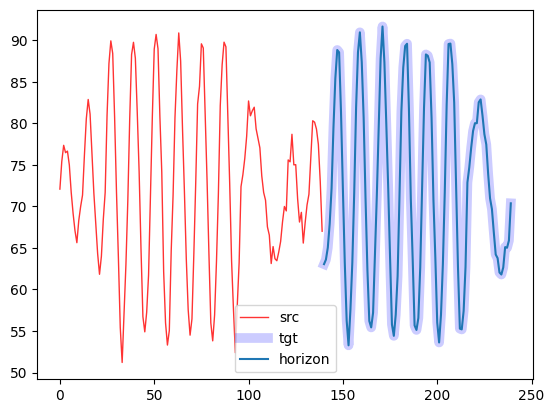

In [43]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

ith = 0 # i-th time series

plt.plot(src_X, src_fX[:, ith], 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX[:, ith], '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:, ith], tgt_fX[-shift-1:, ith], label='horizon')
plt.legend()

src_X.shape, src_fX.shape, tgt_X.shape, tgt_fX.shape

### Training setup

In [44]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1, 
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Training

In [45]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1828.7710	val_loss=699.6995	train_mape_loss=0.5466	val_mape_loss=0.4295	R_p=['0.2906', '0.2715']
epoch=1	train_loss=749.5370	val_loss=699.4959	train_mape_loss=0.4303	val_mape_loss=0.4302	R_p=['0.2905', '0.2698']
epoch=2	train_loss=738.2487	val_loss=699.5837	train_mape_loss=0.4284	val_mape_loss=0.4307	R_p=['0.2906', '0.2691']
epoch=3	train_loss=730.3146	val_loss=696.1592	train_mape_loss=0.4270	val_mape_loss=0.4144	R_p=['0.2881', '0.2930']
epoch=4	train_loss=725.3303	val_loss=695.8708	train_mape_loss=0.4259	val_mape_loss=0.4159	R_p=['0.2878', '0.2893']
epoch=5	train_loss=721.9224	val_loss=696.6165	train_mape_loss=0.4254	val_mape_loss=0.4123	R_p=['0.2885', '0.2982']
epoch=6	train_loss=719.3404	val_loss=695.8730	train_mape_loss=0.4247	val_mape_loss=0.4191	R_p=['0.2879', '0.2835']
epoch=7	train_loss=718.3388	val_loss=696.7559	train_mape_loss=0.4246	val_mape_loss=0.4238	R_p=['0.2887', '0.2769']
epoch=8	train_loss=716.8700	val_loss=695.7624	train_mape_loss=0.4242	val_mape_l

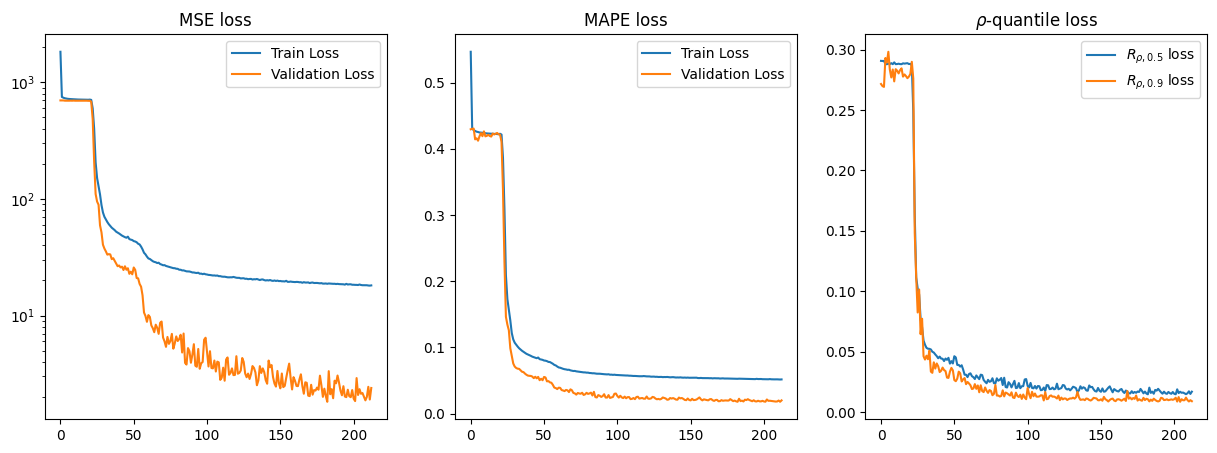

In [46]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

### Testing model

In [47]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(2.3980916652679443,
 0.0200998003333807,
 [0.016993964090943336, 0.008976686745882034])

In [48]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [49]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(1.8131377763748169,
 0.01791438338160515,
 tensor([0.0147, 0.0107], device='cuda:0'))

### Predict

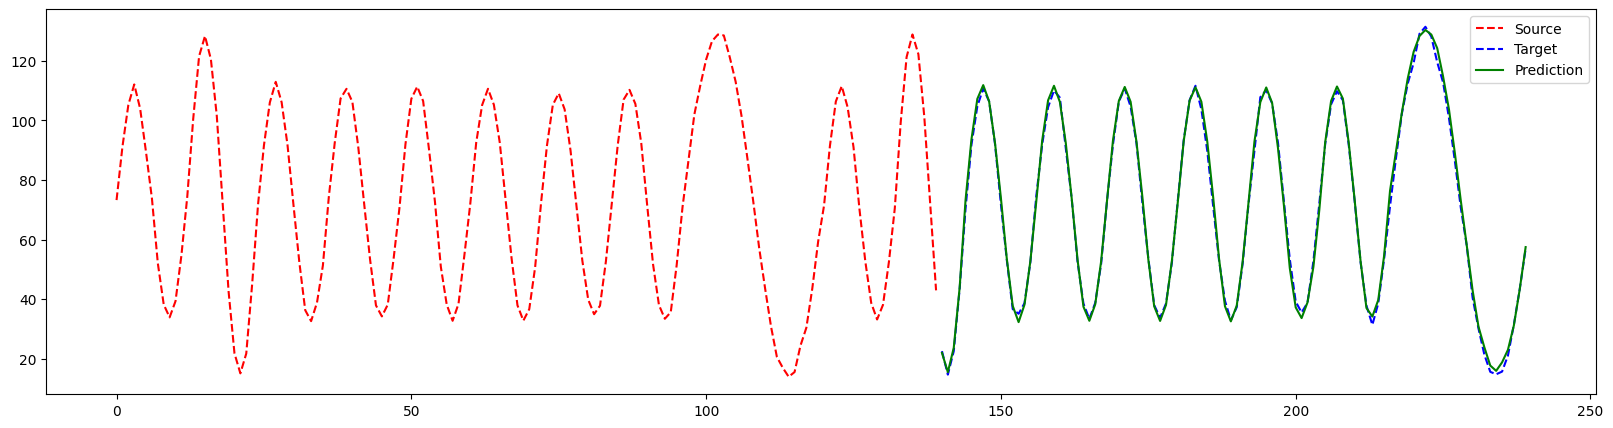

In [50]:
idx = 0 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)
    
    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()
    
    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()
    
    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

ith = 3

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source")
plt.plot(tgt_X, tgt_fX[:, ith], '--b', label="Target")
plt.plot(tgt_X, pred_fX[:, ith], '-g', label="Prediction")
plt.legend()

In [51]:
inspect_step = 0

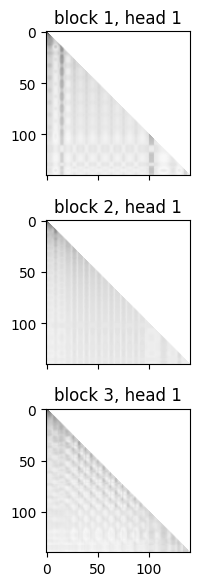

In [52]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

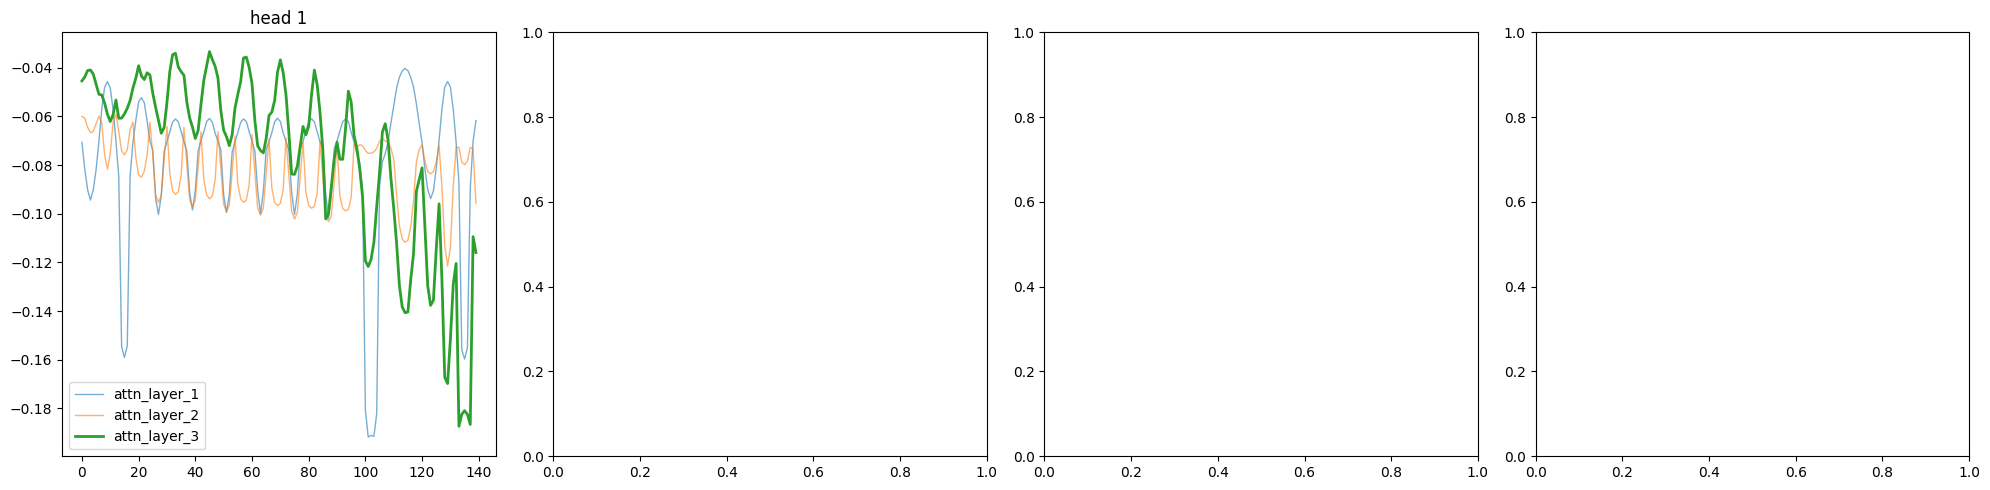

In [53]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten() 

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

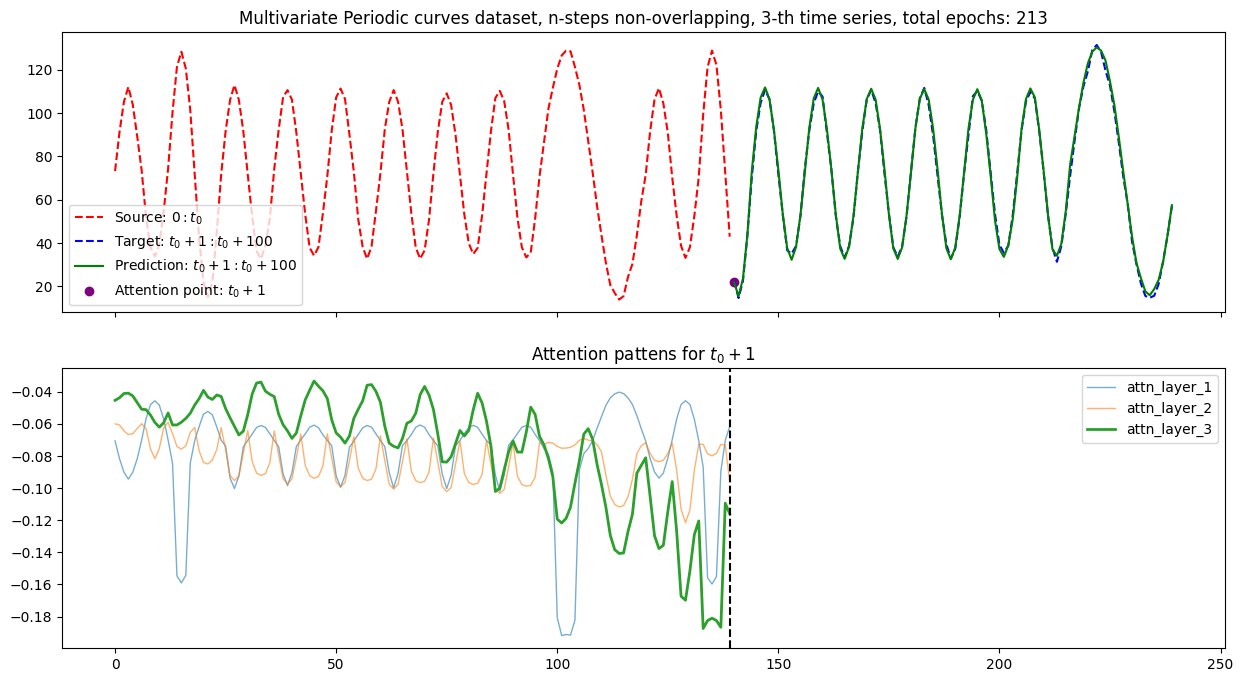

In [54]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu()[:, ith], '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX[:, ith], '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX[:, ith], '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step, ith].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"Multivariate Periodic curves dataset, n-steps non-overlapping, {ith}-th time series, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 5: $n$-step prediction on `(Decaying/Multi)StepSyntheticDataset` with non-overlapping source and target

### Step function

In [55]:
DATASET_NAME = "step"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.StepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

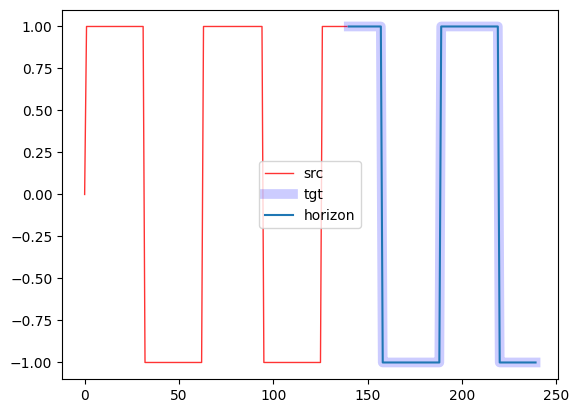

In [56]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [57]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden*2,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [58]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.4343	val_loss=1.0019	train_mape_loss=1.0666	val_mape_loss=1.0005	R_p=['1.0005', '1.0181']
epoch=1	train_loss=1.0205	val_loss=1.0054	train_mape_loss=1.0002	val_mape_loss=1.0006	R_p=['1.0006', '1.0653']
epoch=2	train_loss=1.0141	val_loss=1.0010	train_mape_loss=1.0001	val_mape_loss=1.0002	R_p=['1.0002', '1.0317']
epoch=3	train_loss=1.0119	val_loss=1.0001	train_mape_loss=1.0000	val_mape_loss=0.9993	R_p=['0.9993', '0.9858']
epoch=4	train_loss=1.0092	val_loss=1.0003	train_mape_loss=0.9998	val_mape_loss=0.9991	R_p=['0.9991', '0.9781']
epoch=5	train_loss=1.0093	val_loss=0.9998	train_mape_loss=1.0001	val_mape_loss=0.9999	R_p=['0.9999', '1.0148']
epoch=6	train_loss=1.0087	val_loss=1.0004	train_mape_loss=1.0001	val_mape_loss=1.0001	R_p=['1.0001', '1.0222']
epoch=7	train_loss=1.0082	val_loss=0.9998	train_mape_loss=1.0003	val_mape_loss=0.9996	R_p=['0.9996', '0.9980']
epoch=8	train_loss=1.0073	val_loss=1.0013	train_mape_loss=0.9997	val_mape_loss=0.9990	R_p=['0.9990', '0.9673']
e

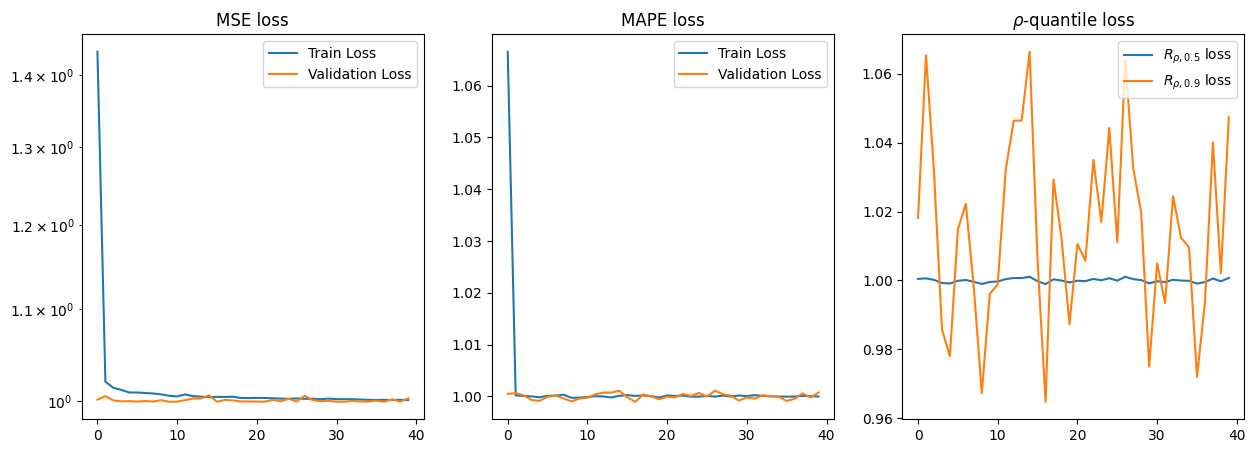

In [59]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [60]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(1.0011547813415527,
 0.9997408838272095,
 [0.9997409582138062, 1.0274853706359863])

In [61]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [62]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(1.0008069734573364,
 1.000144100189209,
 tensor([1.0001, 0.9778], device='cuda:0'))

#### Predict

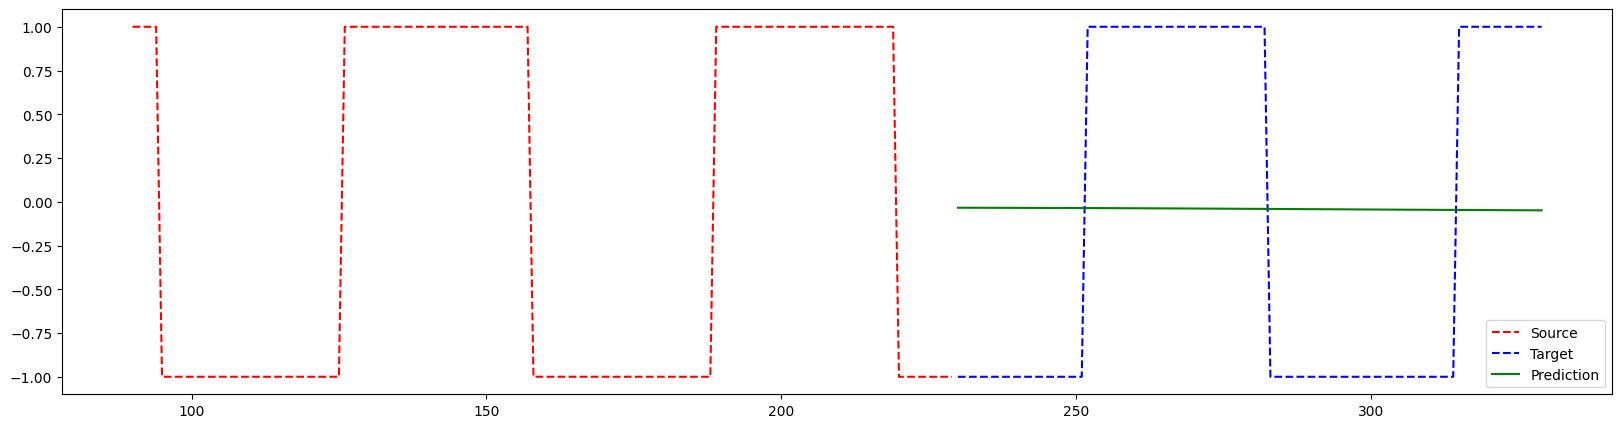

In [63]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [64]:
inspect_step = 0

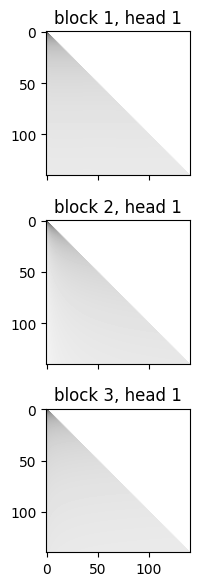

In [65]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

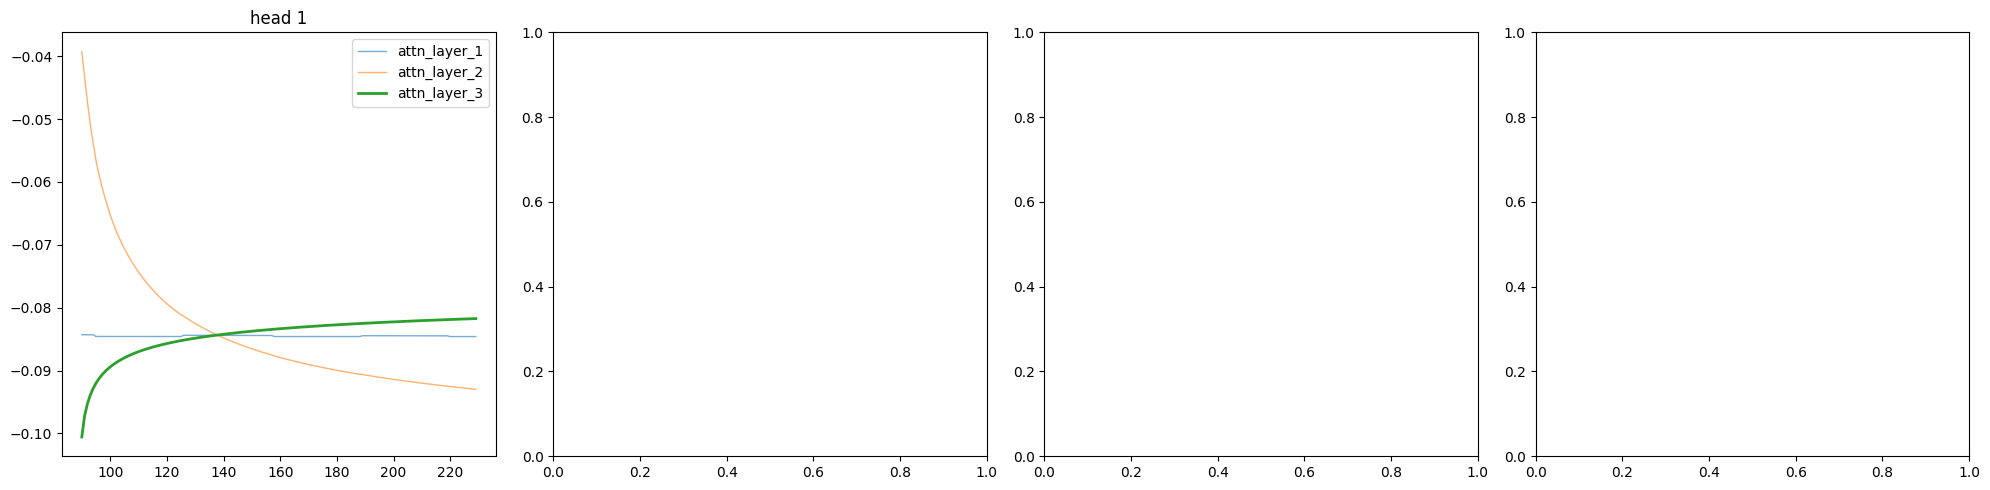

In [66]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

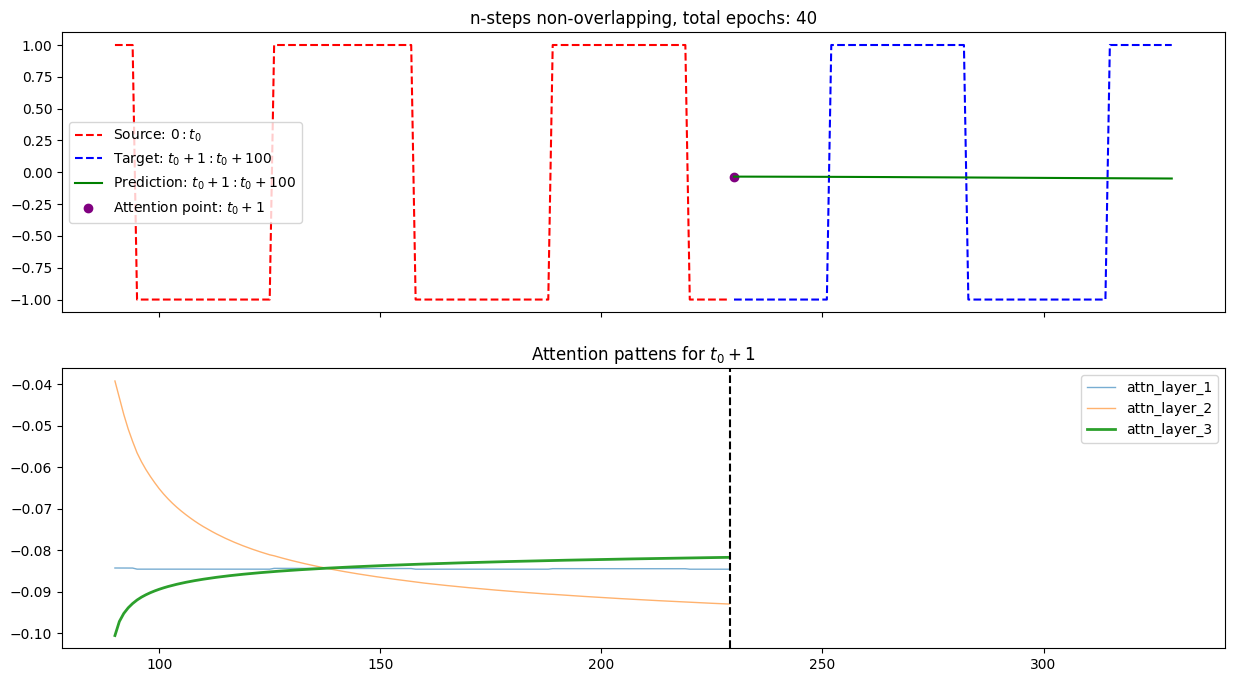

In [67]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Step function

In [68]:
DATASET_NAME = "step_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

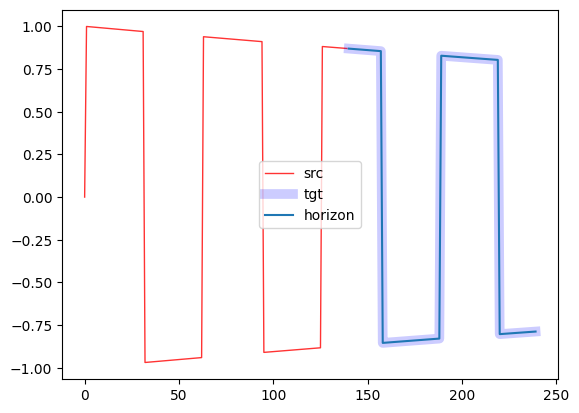

In [69]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [70]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [71]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.2144	val_loss=0.0581	train_mape_loss=19.7672	val_mape_loss=2.5152	R_p=['1.0550', '0.8930']
epoch=1	train_loss=0.0666	val_loss=0.0595	train_mape_loss=6.3400	val_mape_loss=4.0822	R_p=['1.1279', '1.4031']
epoch=2	train_loss=0.0630	val_loss=0.0573	train_mape_loss=5.1013	val_mape_loss=1.2315	R_p=['1.0053', '1.0450']
epoch=3	train_loss=0.0616	val_loss=0.0583	train_mape_loss=4.4404	val_mape_loss=2.9167	R_p=['1.0707', '1.2543']
epoch=4	train_loss=0.0608	val_loss=0.0574	train_mape_loss=4.0572	val_mape_loss=1.4442	R_p=['1.0124', '0.9402']
epoch=5	train_loss=0.0605	val_loss=0.0573	train_mape_loss=3.8758	val_mape_loss=1.1148	R_p=['1.0027', '0.9665']
epoch=6	train_loss=0.0600	val_loss=0.0575	train_mape_loss=3.5635	val_mape_loss=1.8281	R_p=['1.0245', '1.1192']
epoch=7	train_loss=0.0597	val_loss=0.0573	train_mape_loss=3.3660	val_mape_loss=1.1097	R_p=['1.0019', '1.0287']
epoch=8	train_loss=0.0596	val_loss=0.0575	train_mape_loss=3.3492	val_mape_loss=1.6934	R_p=['1.0196', '1.1027']


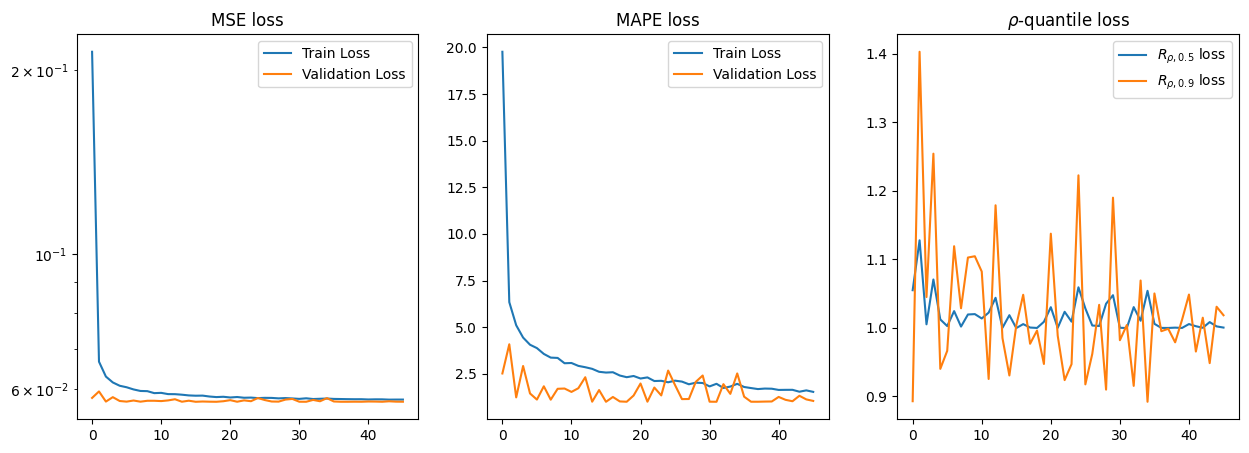

In [72]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [73]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.055676366299390795,
 1.0542640295028687,
 [1.0012695789337158, 1.0248780250549316])

In [74]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [75]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.05566051828861236,
 0.9992498874664306,
 tensor([1.0001, 1.0089], device='cuda:0'))

#### Predict

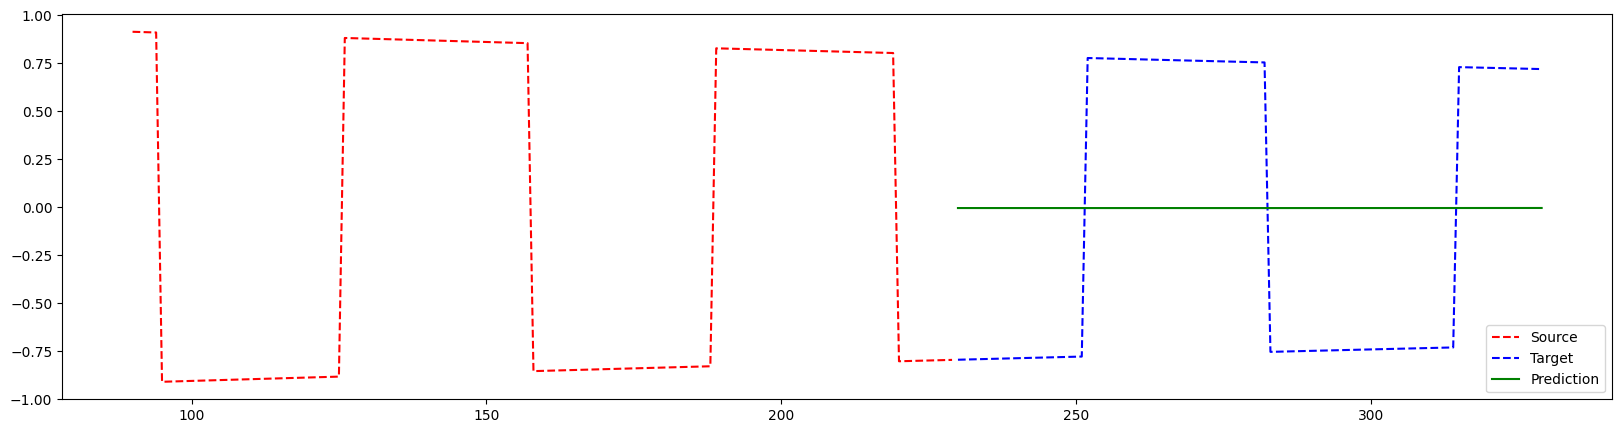

In [76]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [77]:
inspect_step = 0

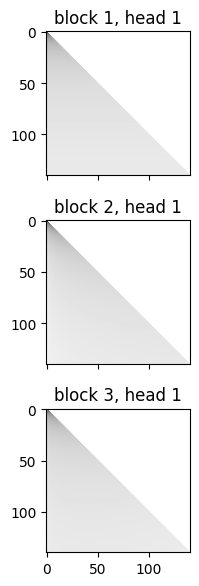

In [78]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

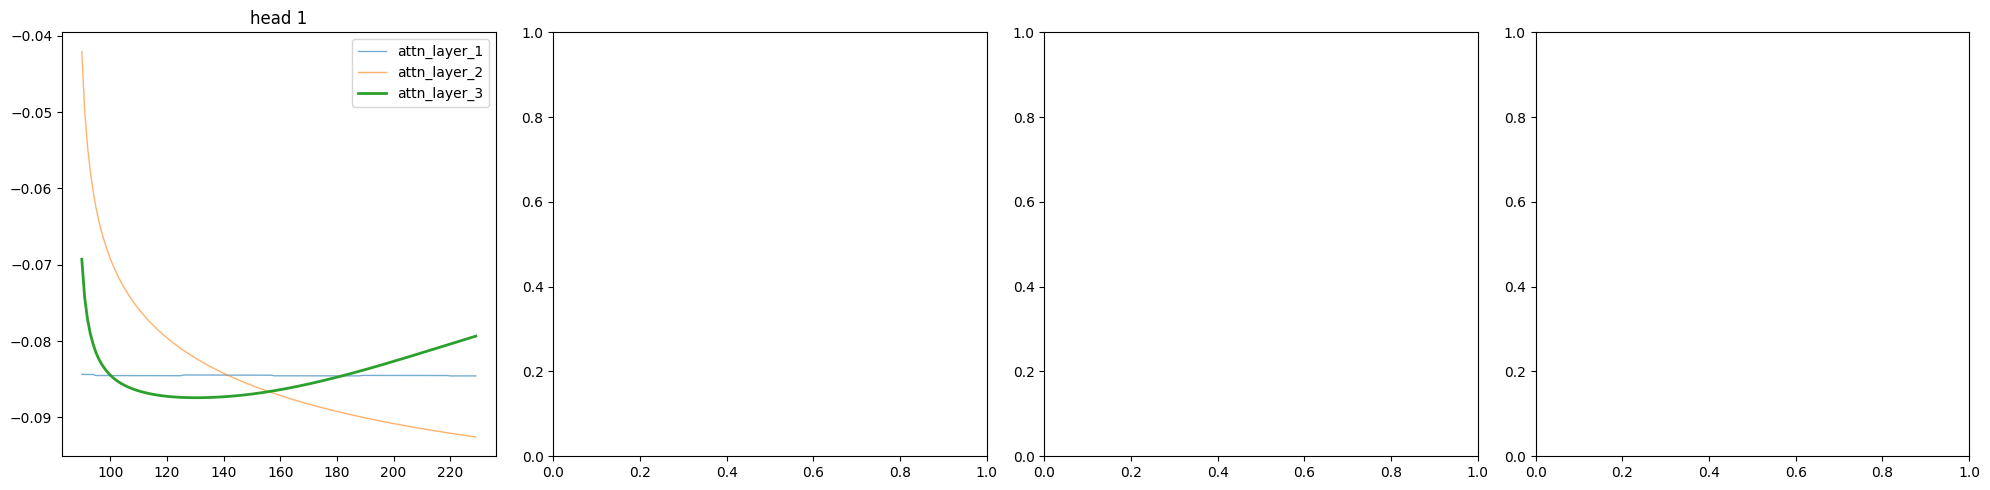

In [79]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

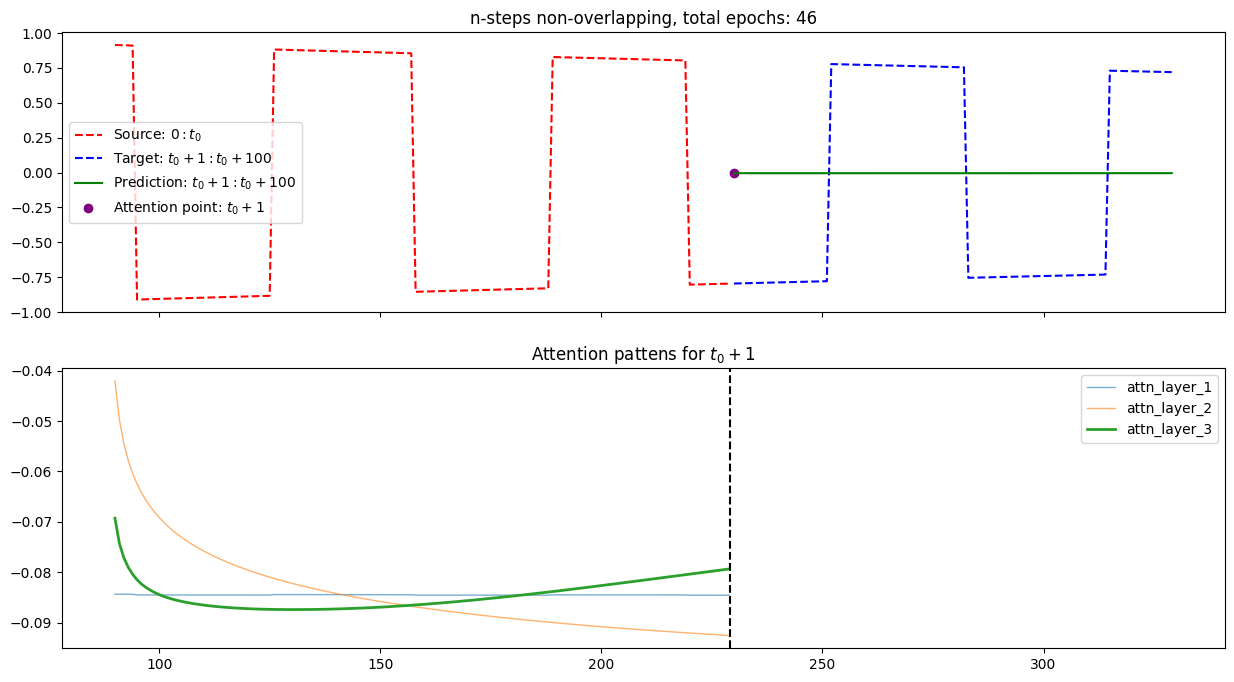

In [80]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Step function

In [81]:
DATASET_NAME = "step_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleStepSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

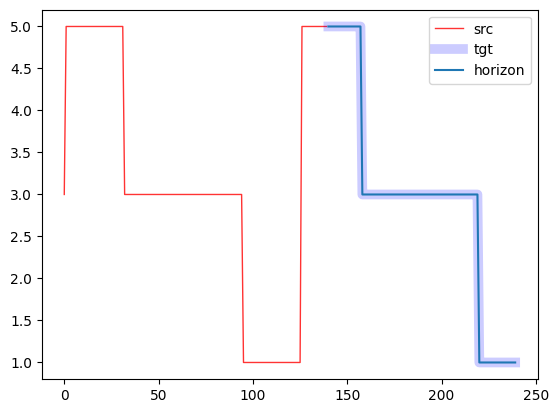

In [82]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [83]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [84]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=2.4931	val_loss=2.0378	train_mape_loss=0.6730	val_mape_loss=0.6049	R_p=['0.3444', '0.3566']
epoch=1	train_loss=2.0489	val_loss=2.0833	train_mape_loss=0.6272	val_mape_loss=0.6867	R_p=['0.3738', '0.3185']
epoch=2	train_loss=2.0372	val_loss=2.0374	train_mape_loss=0.6245	val_mape_loss=0.6091	R_p=['0.3398', '0.3410']
epoch=3	train_loss=2.0303	val_loss=2.0459	train_mape_loss=0.6222	val_mape_loss=0.6023	R_p=['0.3500', '0.3738']
epoch=4	train_loss=2.0279	val_loss=2.0660	train_mape_loss=0.6210	val_mape_loss=0.6726	R_p=['0.3677', '0.3225']
epoch=5	train_loss=2.0255	val_loss=2.0428	train_mape_loss=0.6203	val_mape_loss=0.6084	R_p=['0.3431', '0.3503']
epoch=6	train_loss=2.0239	val_loss=2.0684	train_mape_loss=0.6198	val_mape_loss=0.6743	R_p=['0.3684', '0.3220']
epoch=7	train_loss=2.0228	val_loss=2.0464	train_mape_loss=0.6195	val_mape_loss=0.6475	R_p=['0.3567', '0.3296']
epoch=8	train_loss=2.0199	val_loss=2.0370	train_mape_loss=0.6189	val_mape_loss=0.6269	R_p=['0.3477', '0.3356']
e

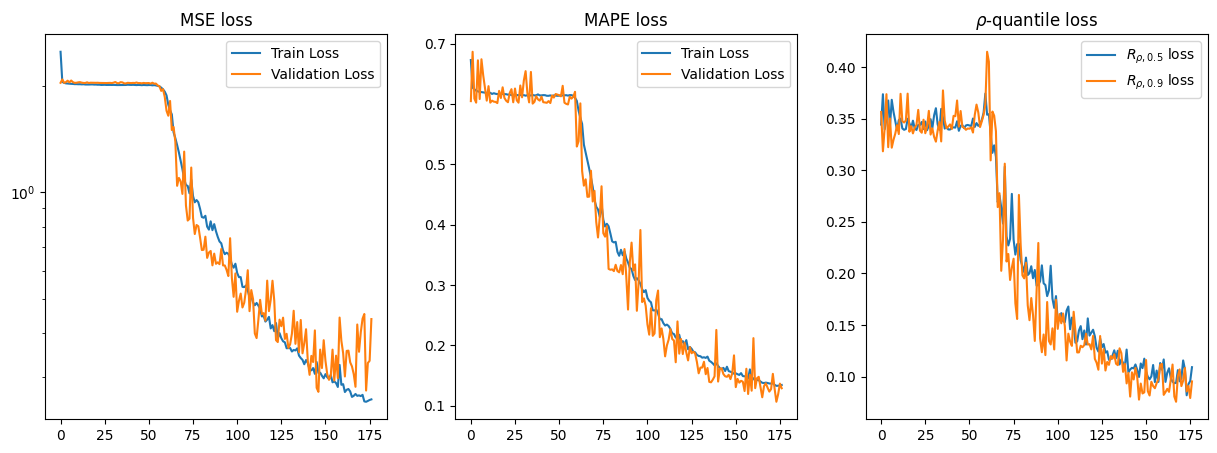

In [85]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [86]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.4565912754535675,
 0.1293689172267914,
 [0.11211659014225006, 0.10044097900390625])

In [87]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [88]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.26982154440879824,
 0.14607398235797883,
 tensor([0.0991, 0.0815], device='cuda:0'))

#### Predict

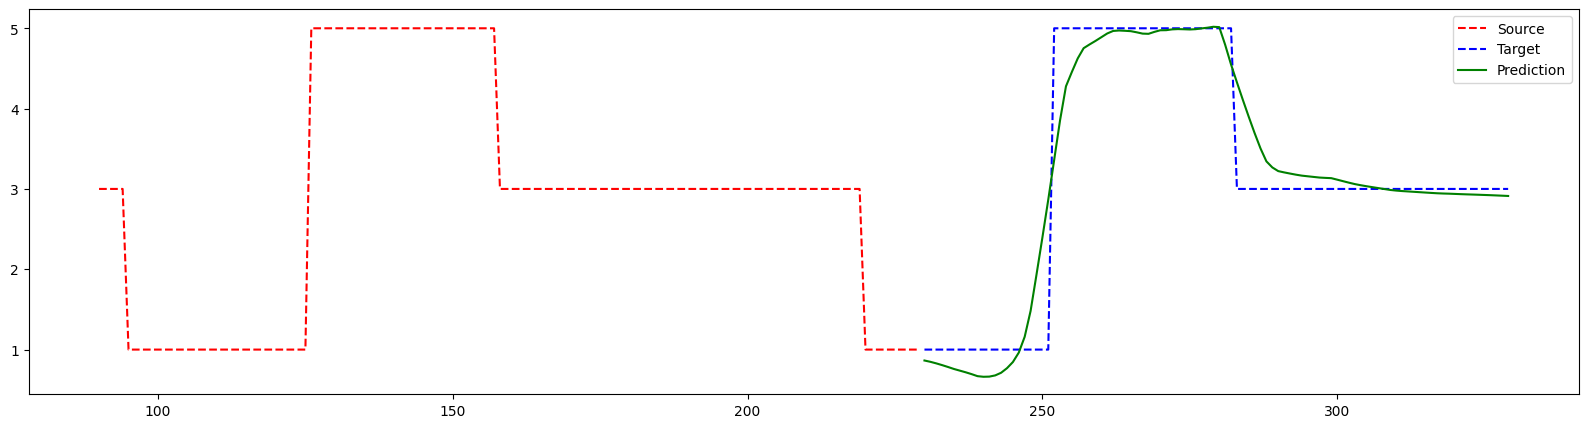

In [89]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [90]:
inspect_step = 0

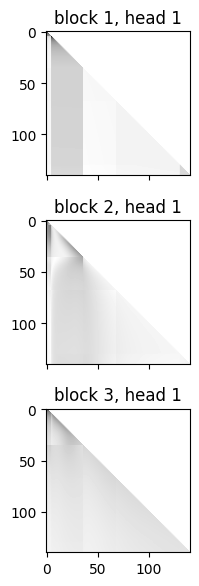

In [91]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

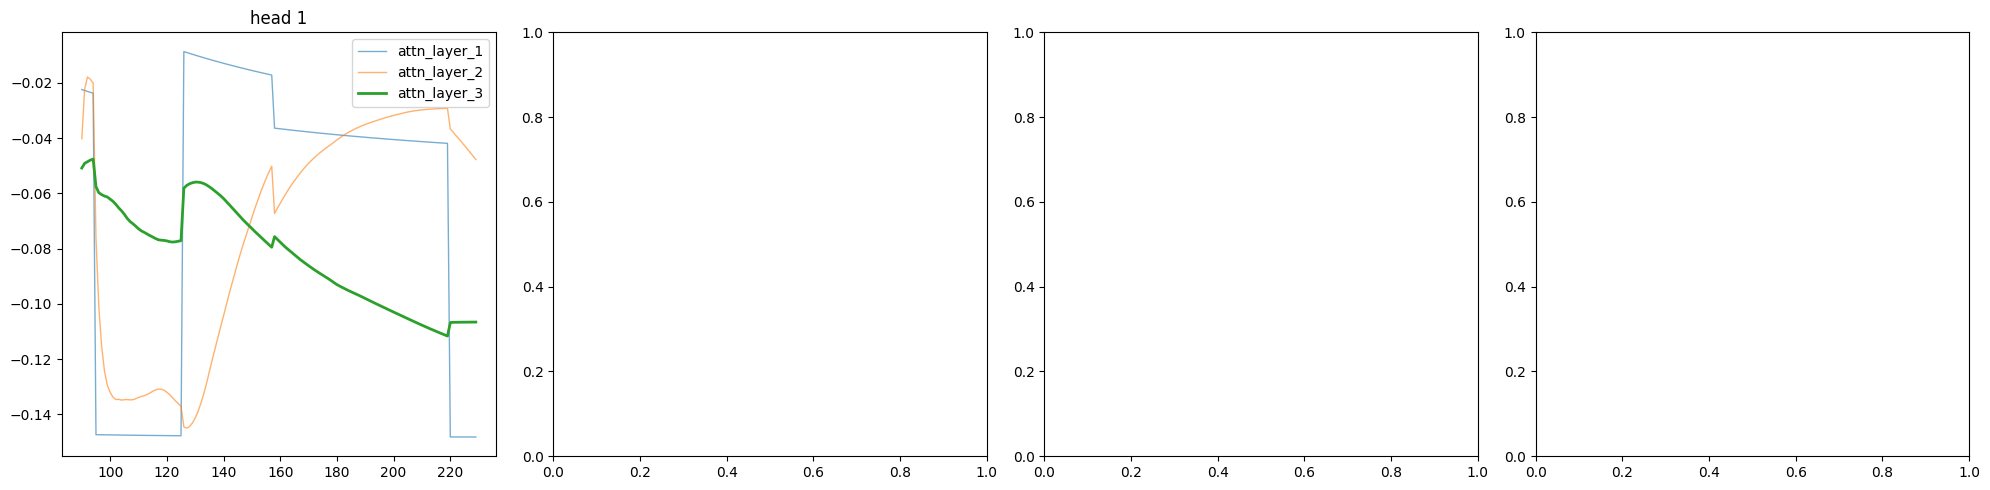

In [92]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

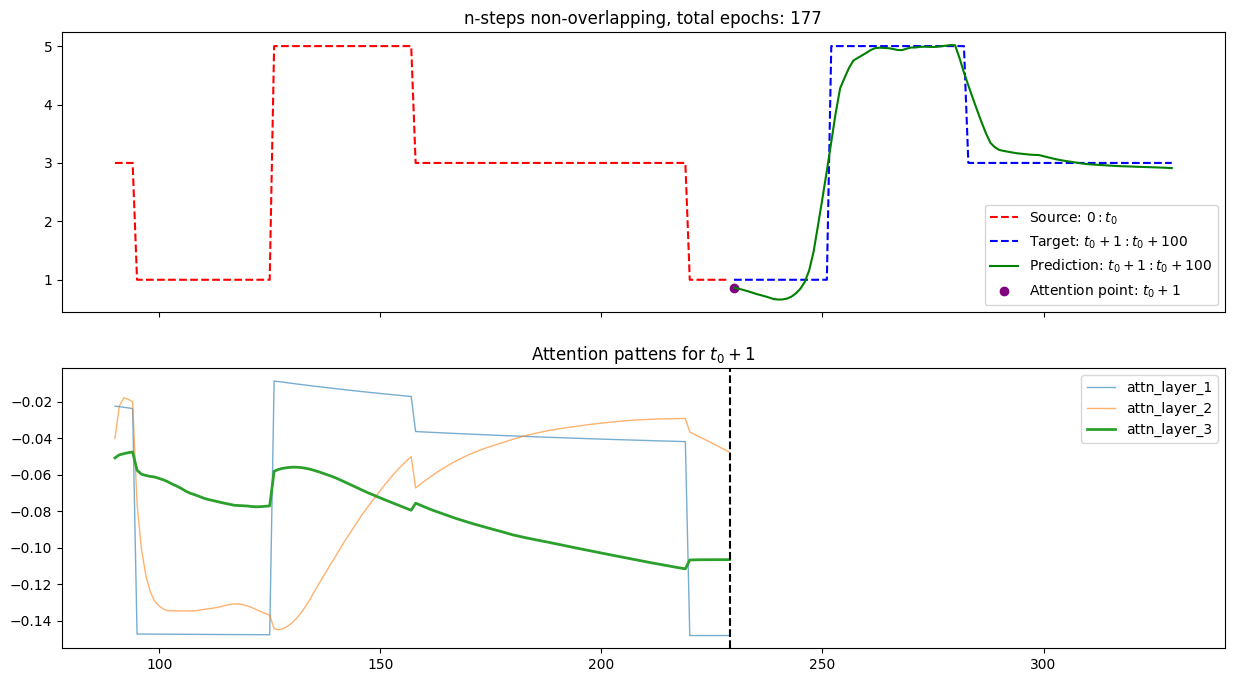

In [93]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 6: $n$-step prediction on `(Decaying/Multi)SineSyntheticDataset` with non-overlapping source and target

### Sine function

In [94]:
DATASET_NAME = "sine"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

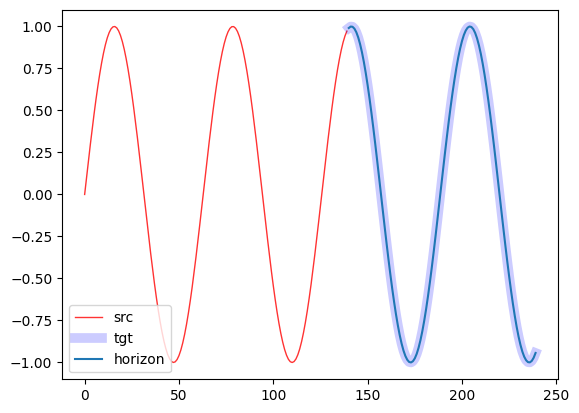

In [95]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [96]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [97]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.7073	val_loss=0.5034	train_mape_loss=3.8070	val_mape_loss=1.2964	R_p=['1.0013', '0.9446']
epoch=1	train_loss=0.5129	val_loss=0.5015	train_mape_loss=1.7058	val_mape_loss=1.0844	R_p=['1.0000', '1.0028']
epoch=2	train_loss=0.5080	val_loss=0.5018	train_mape_loss=1.6170	val_mape_loss=1.1954	R_p=['1.0000', '1.0215']
epoch=3	train_loss=0.5072	val_loss=0.5016	train_mape_loss=1.5927	val_mape_loss=1.0482	R_p=['1.0001', '0.9816']
epoch=4	train_loss=0.5061	val_loss=0.5034	train_mape_loss=1.5026	val_mape_loss=1.2779	R_p=['1.0012', '0.9465']
epoch=5	train_loss=0.5058	val_loss=0.5036	train_mape_loss=1.4531	val_mape_loss=1.4463	R_p=['1.0006', '1.0591']
epoch=6	train_loss=0.5045	val_loss=0.5018	train_mape_loss=1.4234	val_mape_loss=1.0682	R_p=['1.0003', '0.9773']
epoch=7	train_loss=0.5045	val_loss=0.5014	train_mape_loss=1.3603	val_mape_loss=1.0936	R_p=['0.9999', '1.0056']
epoch=8	train_loss=0.5035	val_loss=0.5014	train_mape_loss=1.3668	val_mape_loss=1.0204	R_p=['1.0000', '0.9909']
e

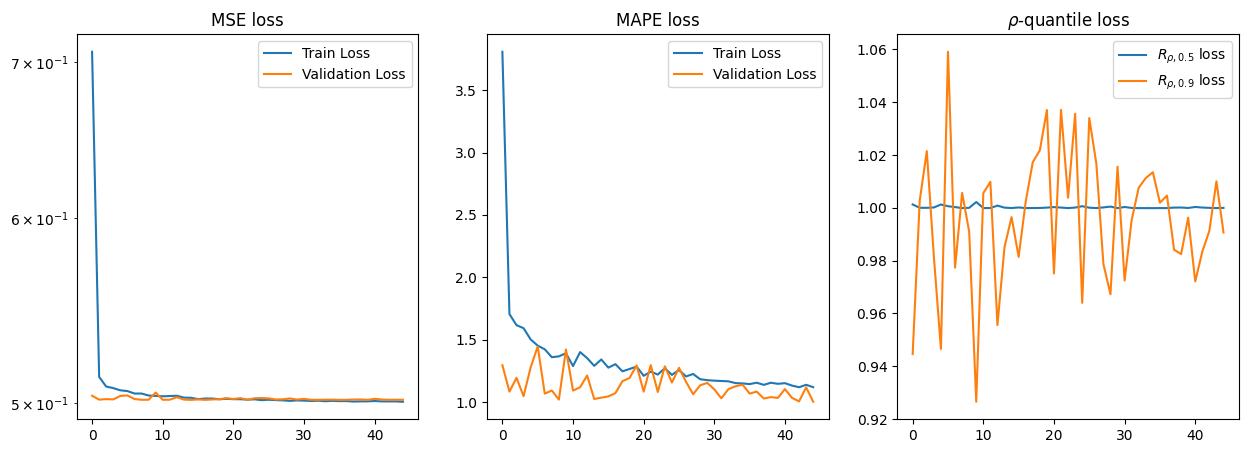

In [98]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [99]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.4990596034526825,
 1.0029910154342652,
 [1.000017523765564, 1.0076082944869995])

In [100]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [101]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.4991389400959015,
 1.0365545673370362,
 tensor([1.0001, 1.0136], device='cuda:0'))

#### Predict

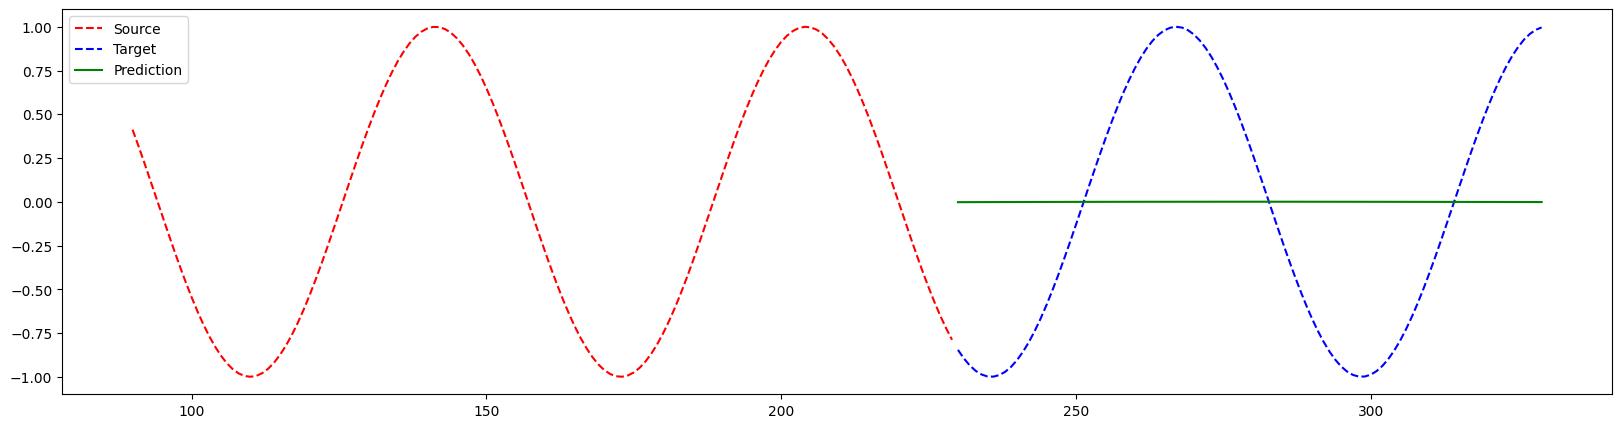

In [102]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [103]:
inspect_step = 0

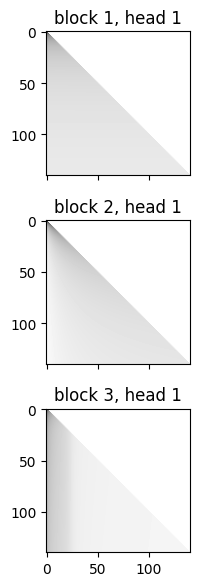

In [104]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

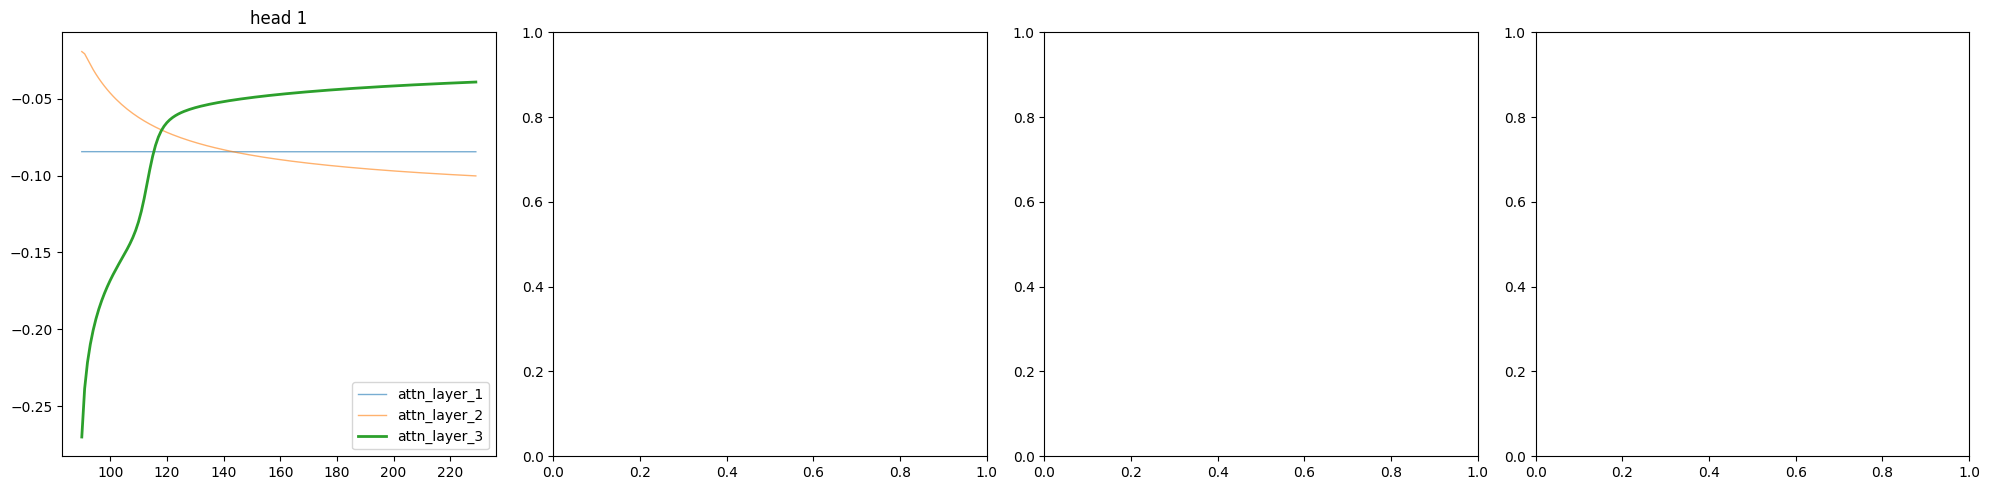

In [105]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

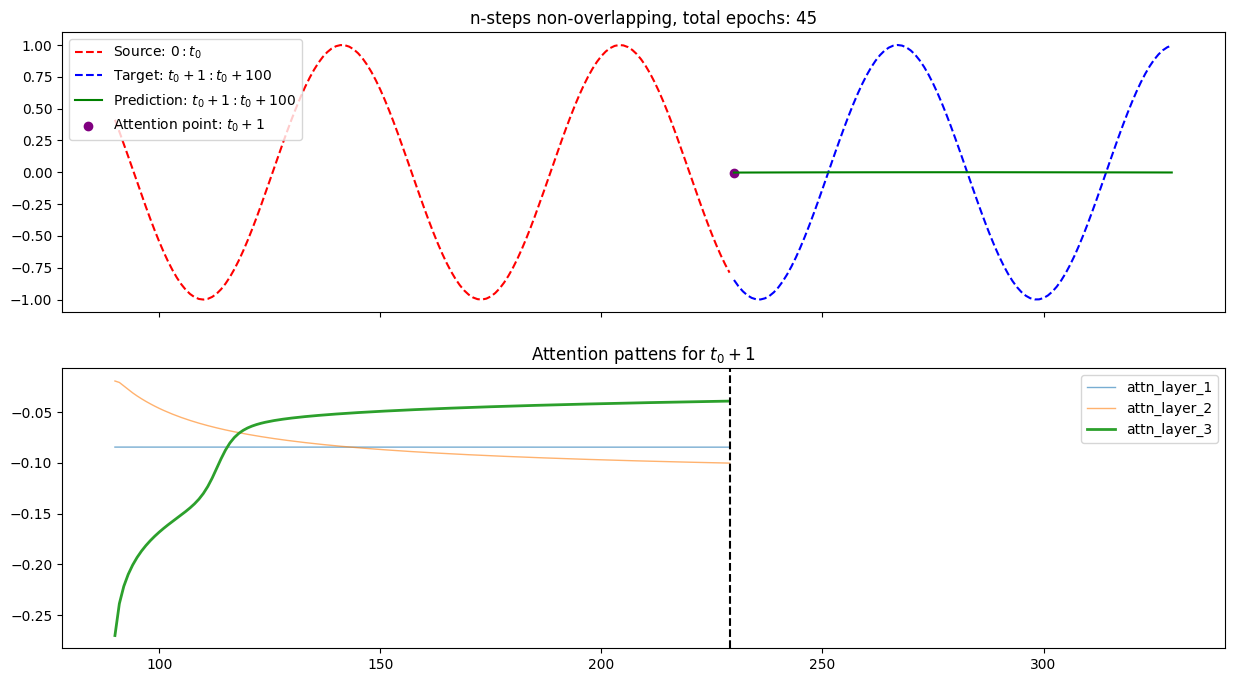

In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sine function

In [107]:
DATASET_NAME = "sine_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

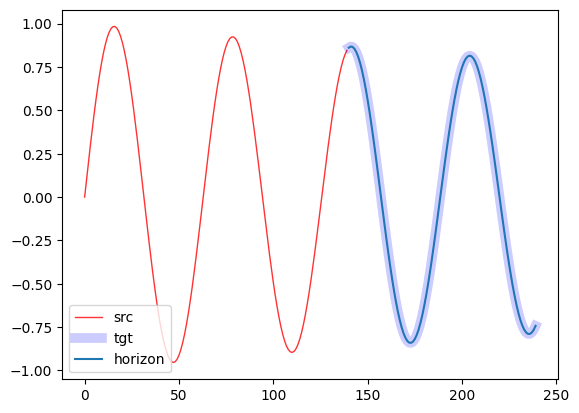

In [108]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [109]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [110]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.2970	val_loss=0.0281	train_mape_loss=184.3777	val_mape_loss=12.4174	R_p=['1.0994', '0.9116']
epoch=1	train_loss=0.0406	val_loss=0.0275	train_mape_loss=49.9097	val_mape_loss=2.9633	R_p=['1.0098', '1.0404']
epoch=2	train_loss=0.0362	val_loss=0.0282	train_mape_loss=41.4886	val_mape_loss=14.4249	R_p=['1.1164', '1.3691']
epoch=3	train_loss=0.0342	val_loss=0.0275	train_mape_loss=33.4310	val_mape_loss=1.2967	R_p=['1.0004', '1.0064']
epoch=4	train_loss=0.0329	val_loss=0.0276	train_mape_loss=29.5227	val_mape_loss=4.0866	R_p=['1.0157', '1.0893']
epoch=5	train_loss=0.0325	val_loss=0.0287	train_mape_loss=29.5693	val_mape_loss=18.1519	R_p=['1.1623', '1.4814']
epoch=6	train_loss=0.0319	val_loss=0.0281	train_mape_loss=27.7694	val_mape_loss=14.5596	R_p=['1.1190', '0.8860']
epoch=7	train_loss=0.0315	val_loss=0.0281	train_mape_loss=25.2586	val_mape_loss=13.5929	R_p=['1.1069', '1.3461']
epoch=8	train_loss=0.0310	val_loss=0.0276	train_mape_loss=22.5167	val_mape_loss=6.2590	R_p=['1.030

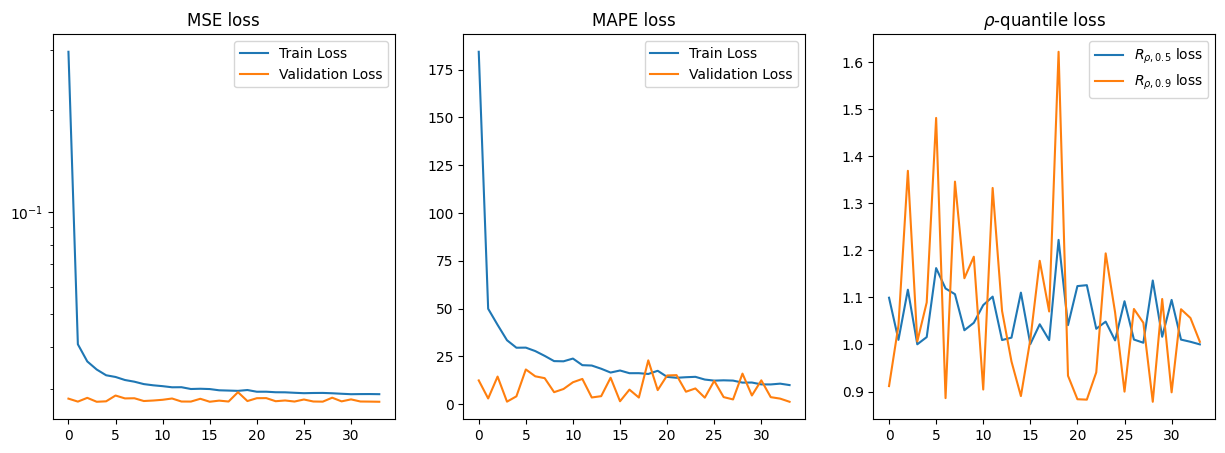

In [111]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [112]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.029531444519758223,
 1.2657391138076781,
 [1.0002251863479614, 0.9966064095497131])

In [113]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [114]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.02953212243318558,
 1.3732355918884278,
 tensor([1.0004, 0.9971], device='cuda:0'))

#### Predict

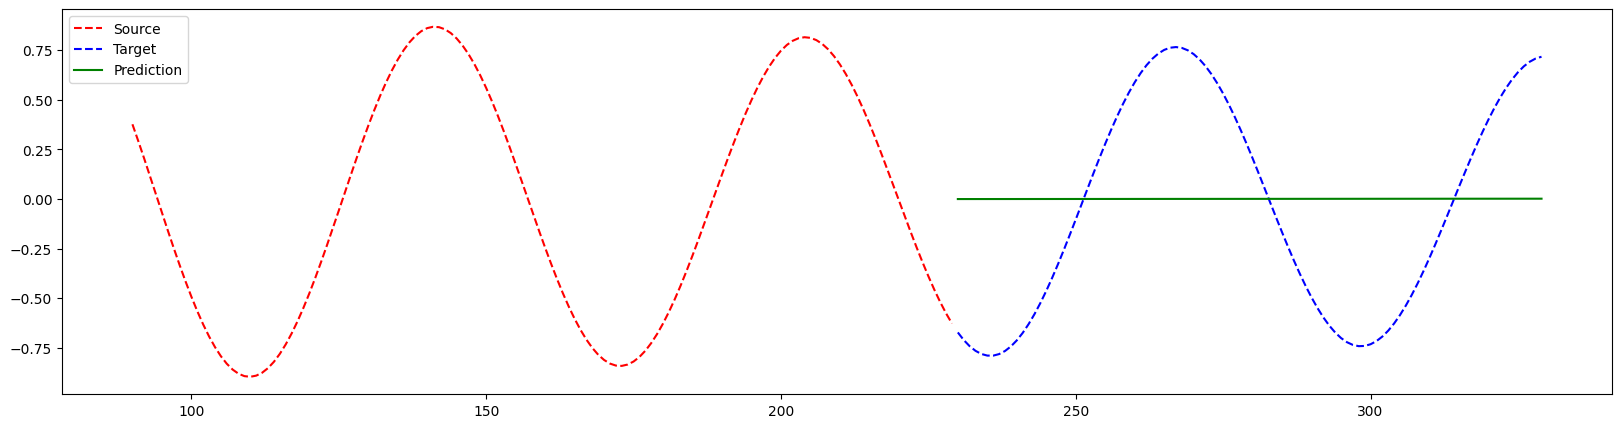

In [115]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [116]:
inspect_step = 0

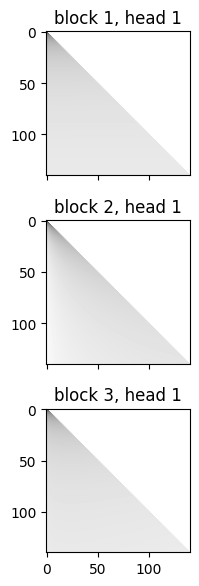

In [117]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

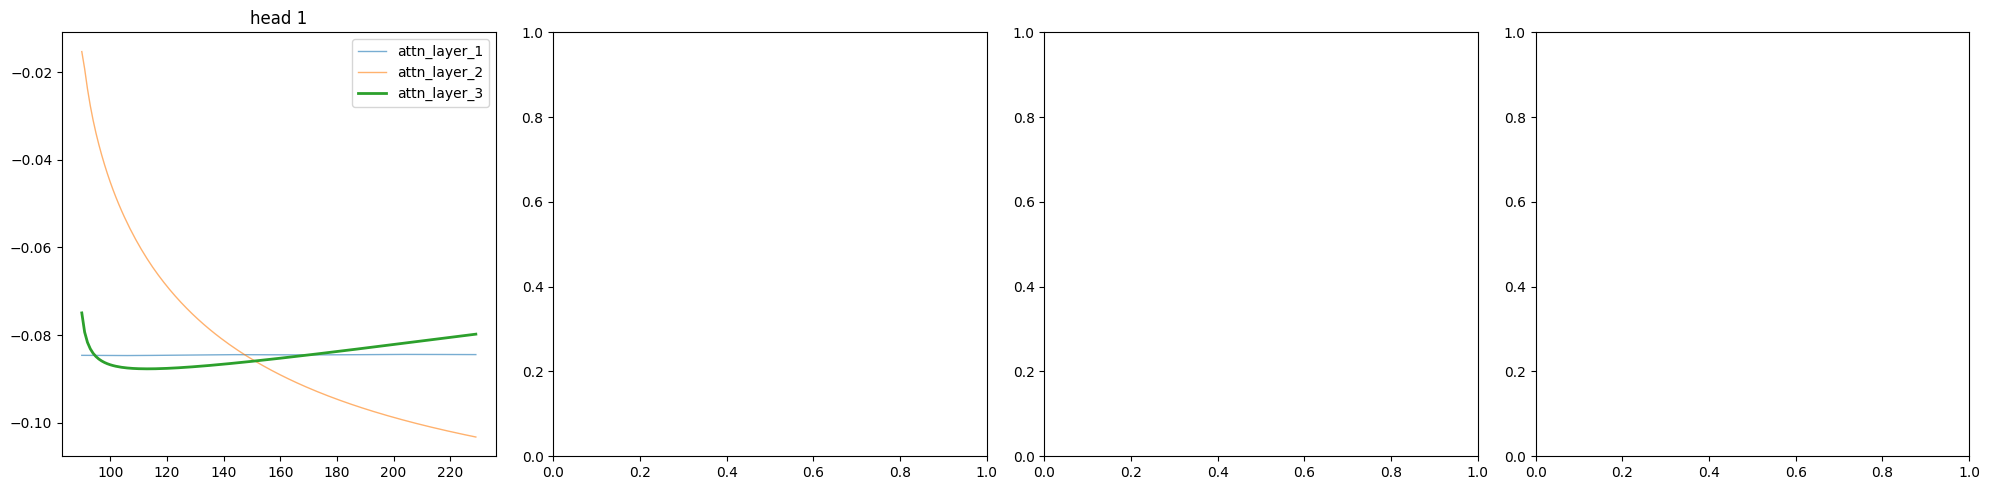

In [118]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

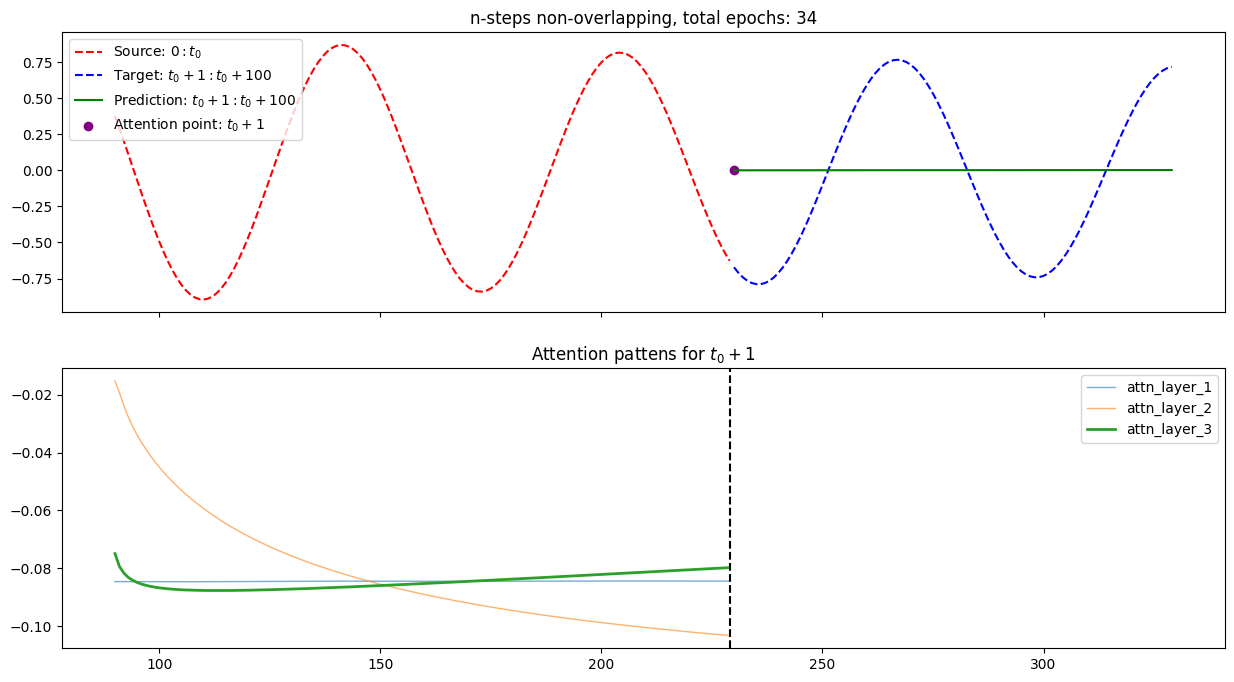

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sine function

In [120]:
DATASET_NAME = "sine_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSineSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

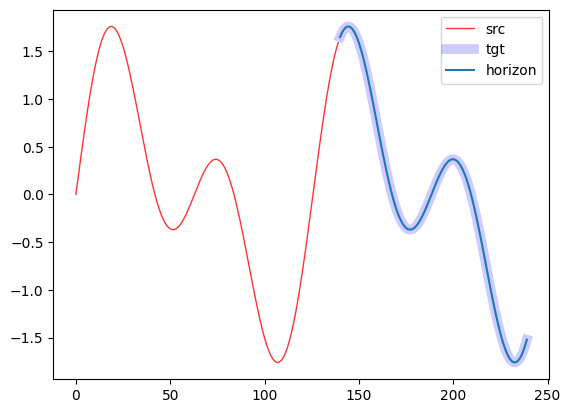

In [121]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [122]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [123]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=1.1766	val_loss=0.9970	train_mape_loss=2.4527	val_mape_loss=1.3406	R_p=['1.0031', '0.9669']
epoch=1	train_loss=1.0155	val_loss=0.9918	train_mape_loss=1.4708	val_mape_loss=1.1215	R_p=['1.0000', '0.9897']
epoch=2	train_loss=1.0108	val_loss=0.9920	train_mape_loss=1.3897	val_mape_loss=1.0609	R_p=['1.0001', '1.0087']
epoch=3	train_loss=1.0092	val_loss=0.9928	train_mape_loss=1.3510	val_mape_loss=1.0509	R_p=['1.0004', '1.0351']
epoch=4	train_loss=1.0072	val_loss=0.9920	train_mape_loss=1.3158	val_mape_loss=1.1744	R_p=['1.0001', '0.9775']
epoch=5	train_loss=1.0064	val_loss=0.9937	train_mape_loss=1.2897	val_mape_loss=1.3050	R_p=['1.0011', '0.9534']
epoch=6	train_loss=1.0053	val_loss=0.9915	train_mape_loss=1.2672	val_mape_loss=1.0602	R_p=['0.9998', '1.0015']
epoch=7	train_loss=1.0048	val_loss=0.9916	train_mape_loss=1.2459	val_mape_loss=1.1235	R_p=['0.9999', '0.9876']
epoch=8	train_loss=1.0045	val_loss=0.9967	train_mape_loss=1.2447	val_mape_loss=1.2332	R_p=['1.0025', '1.0755']
e

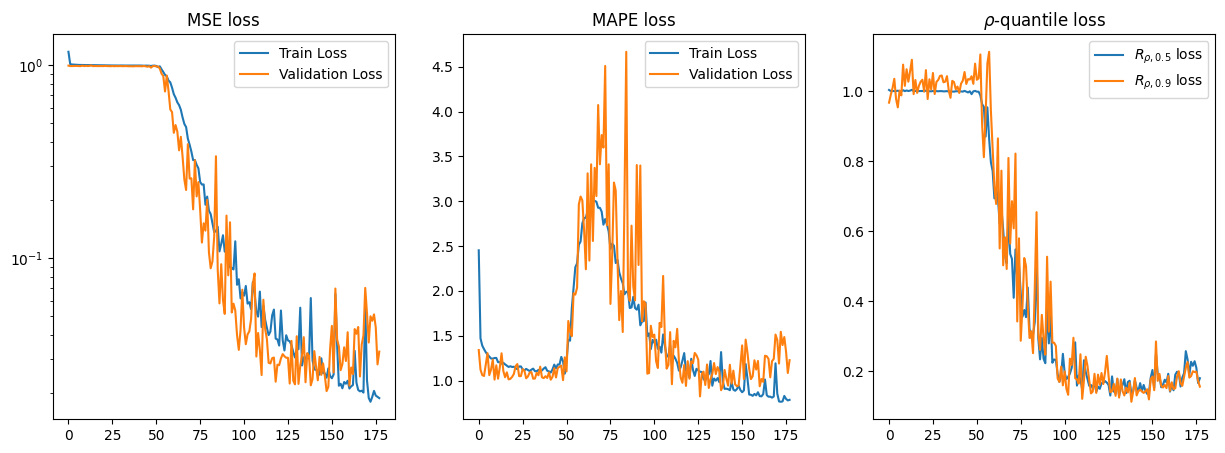

In [124]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [125]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.03429511345922947,
 1.1179675521850585,
 [0.17879381775856018, 0.17118695378303528])

In [126]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [127]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.03425804613530636,
 0.9894912166595459,
 tensor([0.1566, 0.1872], device='cuda:0'))

#### Predict

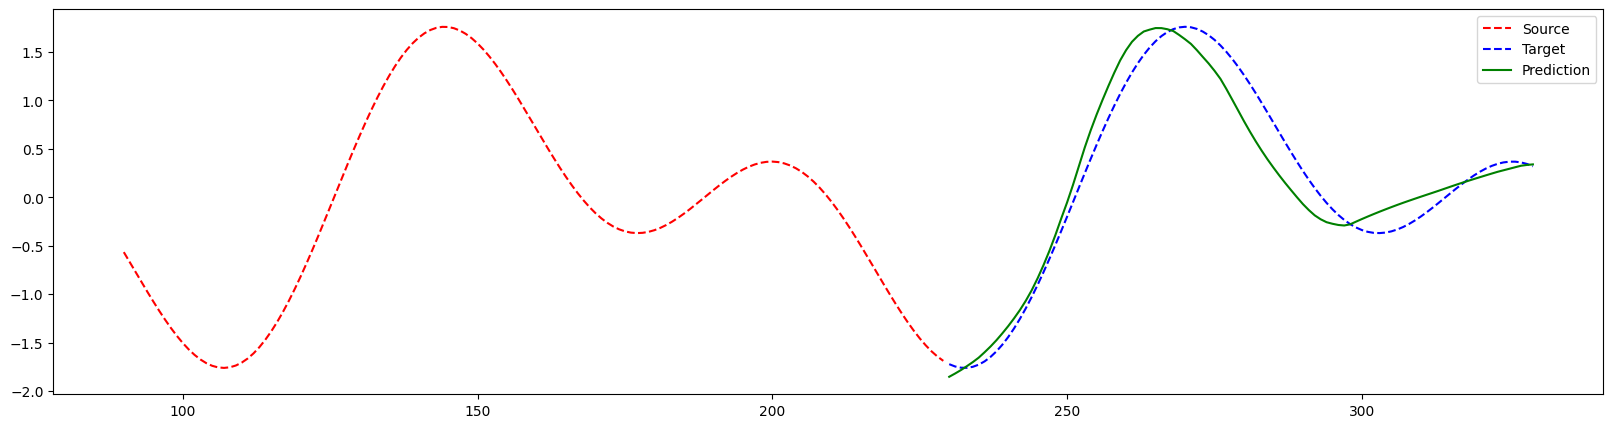

In [128]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [129]:
inspect_step = 0

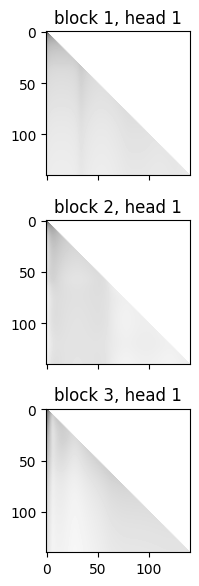

In [130]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

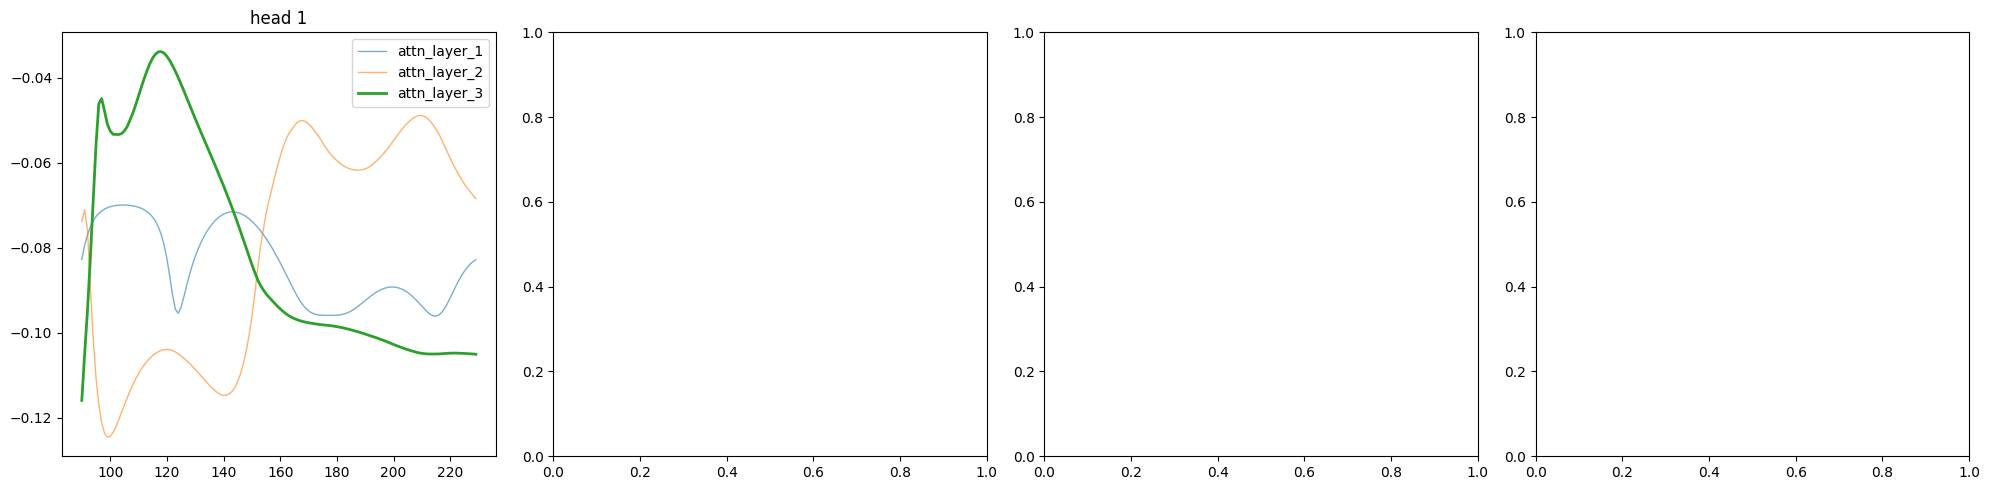

In [131]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

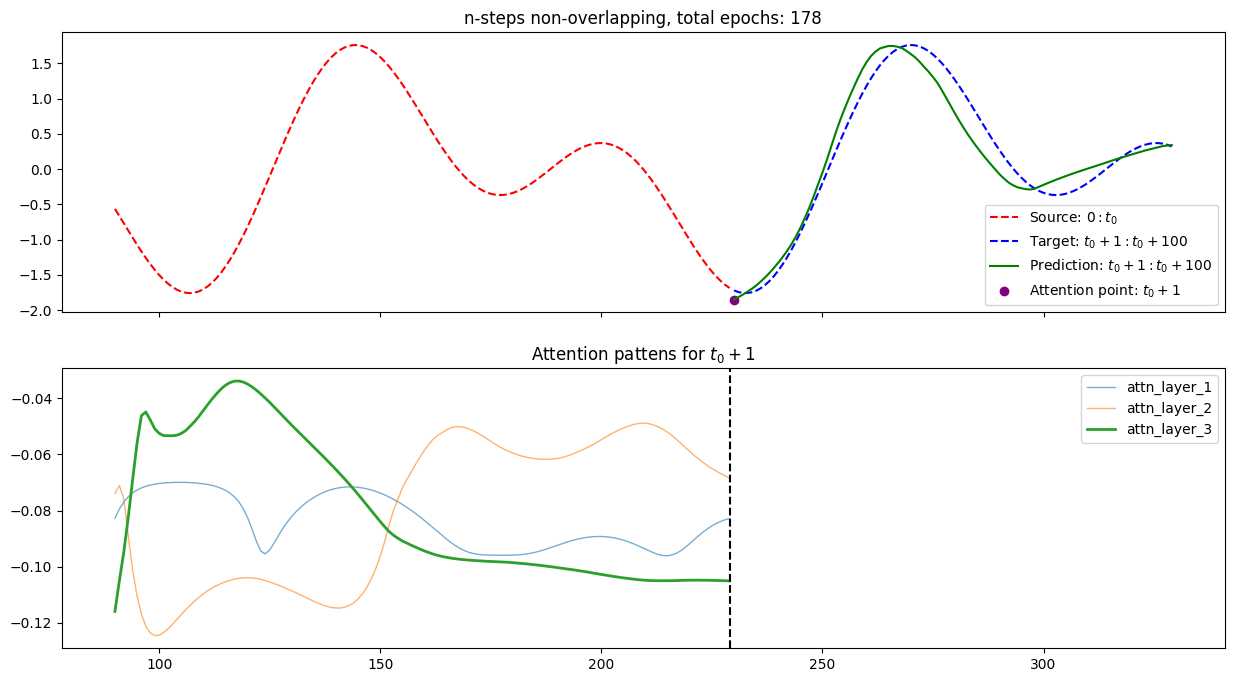

In [132]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

## Experiment 7: $n$-step prediction on `(Decaying/Multi)SawtoothSyntheticDataset` with non-overlapping source and target

### Sawtooth function

In [133]:
DATASET_NAME = "sawtooth"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.SawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha=0.1, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

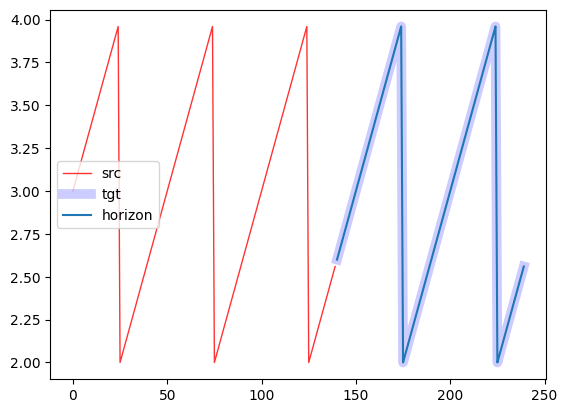

In [134]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [135]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [136]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.6532	val_loss=0.3360	train_mape_loss=0.2225	val_mape_loss=0.1814	R_p=['0.1682', '0.1546']
epoch=1	train_loss=0.3695	val_loss=0.3346	train_mape_loss=0.1837	val_mape_loss=0.1804	R_p=['0.1680', '0.1580']
epoch=2	train_loss=0.3605	val_loss=0.3333	train_mape_loss=0.1822	val_mape_loss=0.1779	R_p=['0.1677', '0.1679']
epoch=3	train_loss=0.3573	val_loss=0.3336	train_mape_loss=0.1817	val_mape_loss=0.1791	R_p=['0.1678', '0.1629']
epoch=4	train_loss=0.3556	val_loss=0.3334	train_mape_loss=0.1814	val_mape_loss=0.1781	R_p=['0.1678', '0.1676']
epoch=5	train_loss=0.3539	val_loss=0.3331	train_mape_loss=0.1812	val_mape_loss=0.1779	R_p=['0.1677', '0.1678']
epoch=6	train_loss=0.3531	val_loss=0.3341	train_mape_loss=0.1810	val_mape_loss=0.1798	R_p=['0.1679', '0.1602']
epoch=7	train_loss=0.3528	val_loss=0.3332	train_mape_loss=0.1810	val_mape_loss=0.1775	R_p=['0.1678', '0.1697']
epoch=8	train_loss=0.3520	val_loss=0.3341	train_mape_loss=0.1808	val_mape_loss=0.1793	R_p=['0.1680', '0.1631']
e

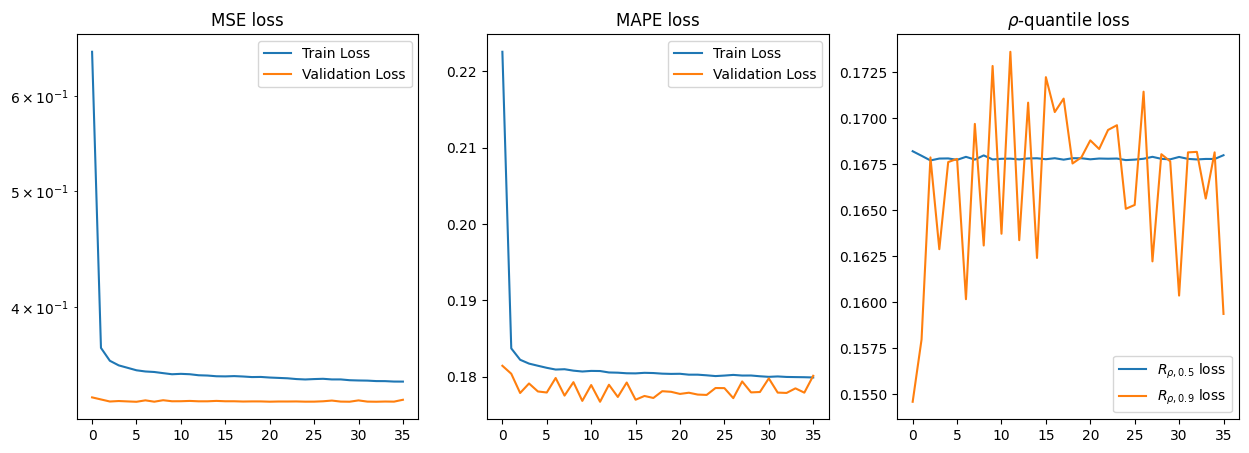

In [137]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [138]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.3343121078014374,
 0.1800921298265457,
 [0.16795861721038818, 0.15932269394397736])

In [139]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [140]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.33321590662002565,
 0.177981565117836,
 tensor([0.1678, 0.1678], device='cuda:0'))

#### Predict

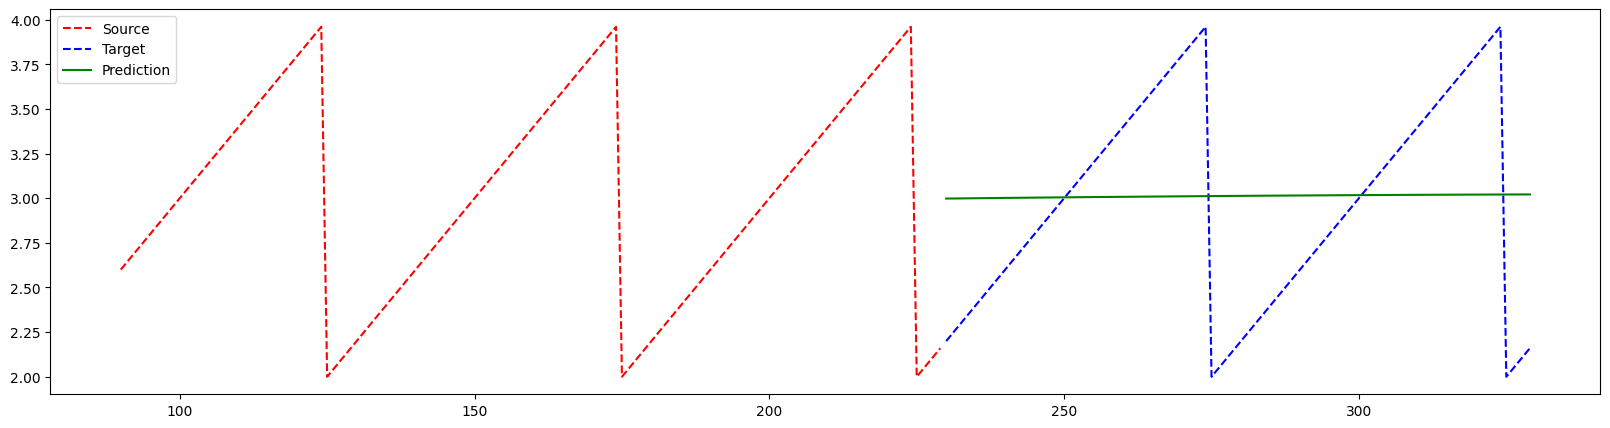

In [141]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [142]:
inspect_step = 0

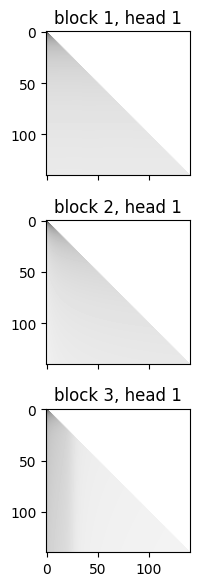

In [143]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

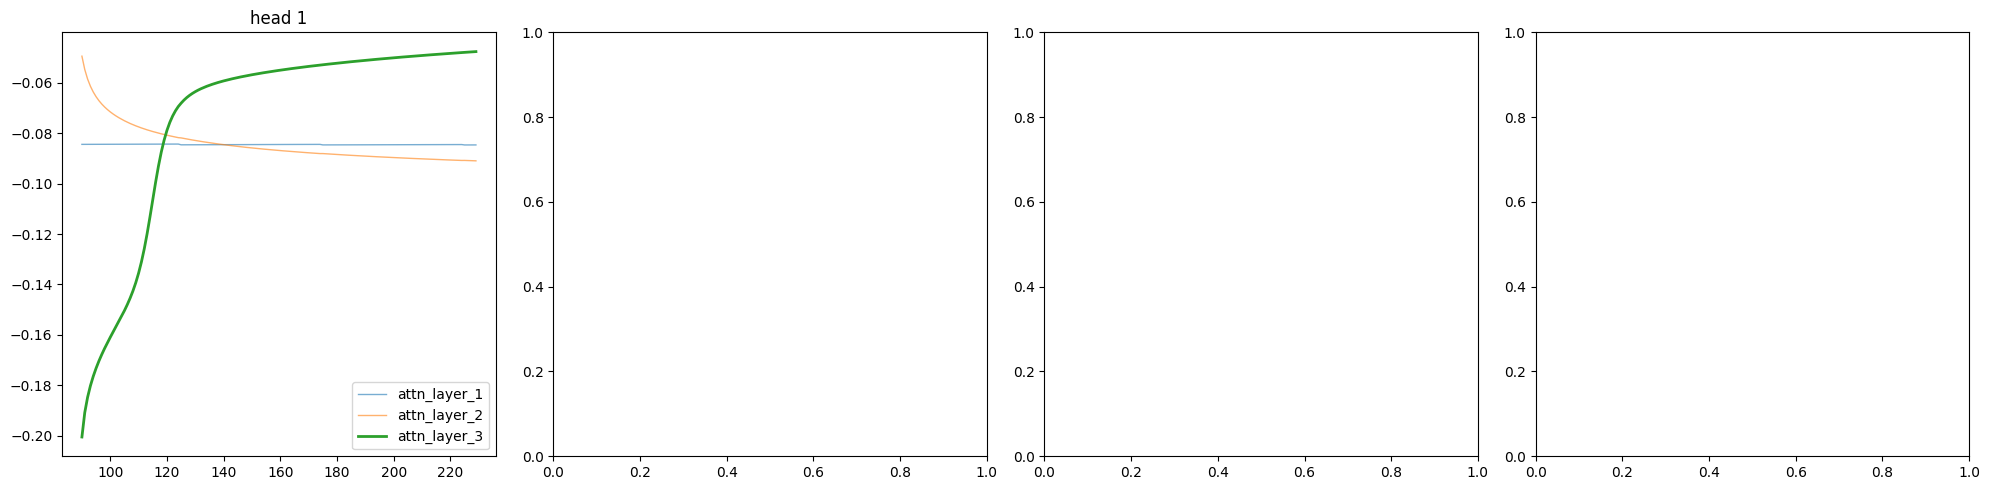

In [144]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

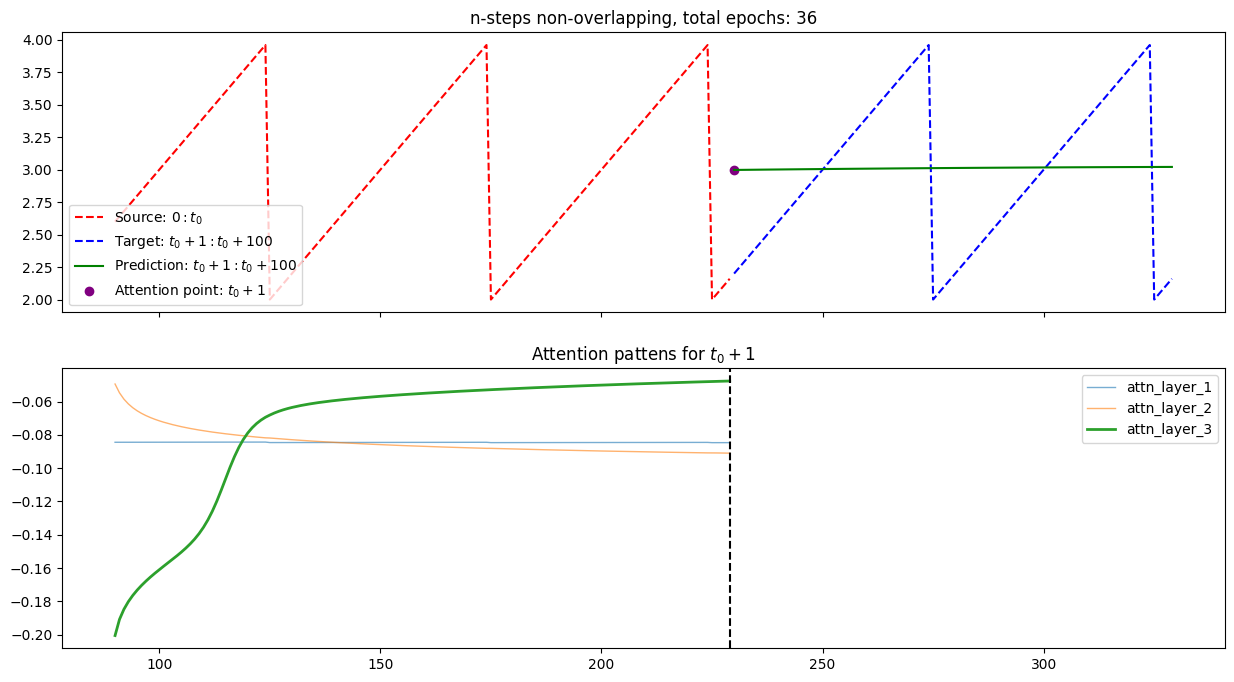

In [145]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Decaying Sawtooth function

In [146]:
DATASET_NAME = "sawtooth_decay"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.DecayingSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.001, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

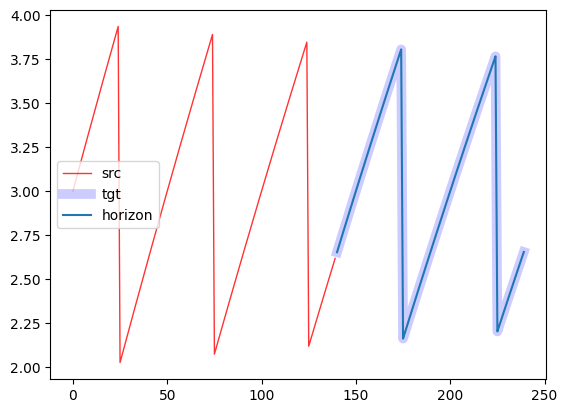

In [147]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [148]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [149]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.3030	val_loss=0.0329	train_mape_loss=0.1200	val_mape_loss=0.0473	R_p=['0.0460', '0.0197']
epoch=1	train_loss=0.0508	val_loss=0.0241	train_mape_loss=0.0578	val_mape_loss=0.0311	R_p=['0.0304', '0.0225']
epoch=2	train_loss=0.0414	val_loss=0.0236	train_mape_loss=0.0514	val_mape_loss=0.0296	R_p=['0.0289', '0.0232']
epoch=3	train_loss=0.0385	val_loss=0.0231	train_mape_loss=0.0492	val_mape_loss=0.0284	R_p=['0.0280', '0.0312']
epoch=4	train_loss=0.0372	val_loss=0.0233	train_mape_loss=0.0482	val_mape_loss=0.0285	R_p=['0.0279', '0.0235']
epoch=5	train_loss=0.0365	val_loss=0.0238	train_mape_loss=0.0476	val_mape_loss=0.0305	R_p=['0.0298', '0.0224']
epoch=6	train_loss=0.0358	val_loss=0.0237	train_mape_loss=0.0470	val_mape_loss=0.0306	R_p=['0.0304', '0.0373']
epoch=7	train_loss=0.0354	val_loss=0.0230	train_mape_loss=0.0468	val_mape_loss=0.0270	R_p=['0.0265', '0.0258']
epoch=8	train_loss=0.0353	val_loss=0.0242	train_mape_loss=0.0466	val_mape_loss=0.0319	R_p=['0.0311', '0.0219']
e

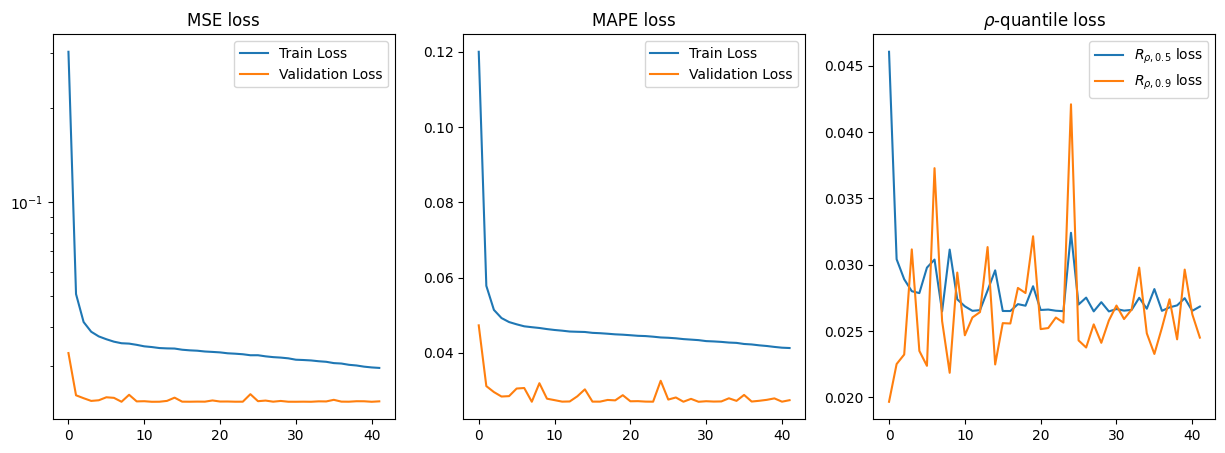

In [150]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [151]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.020330480352044107,
 0.024489057347178458,
 [0.023995930328965187, 0.021753303706645966])

In [152]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [153]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.02026821257174015,
 0.02408892358839512,
 tensor([0.0236, 0.0232], device='cuda:0'))

#### Predict

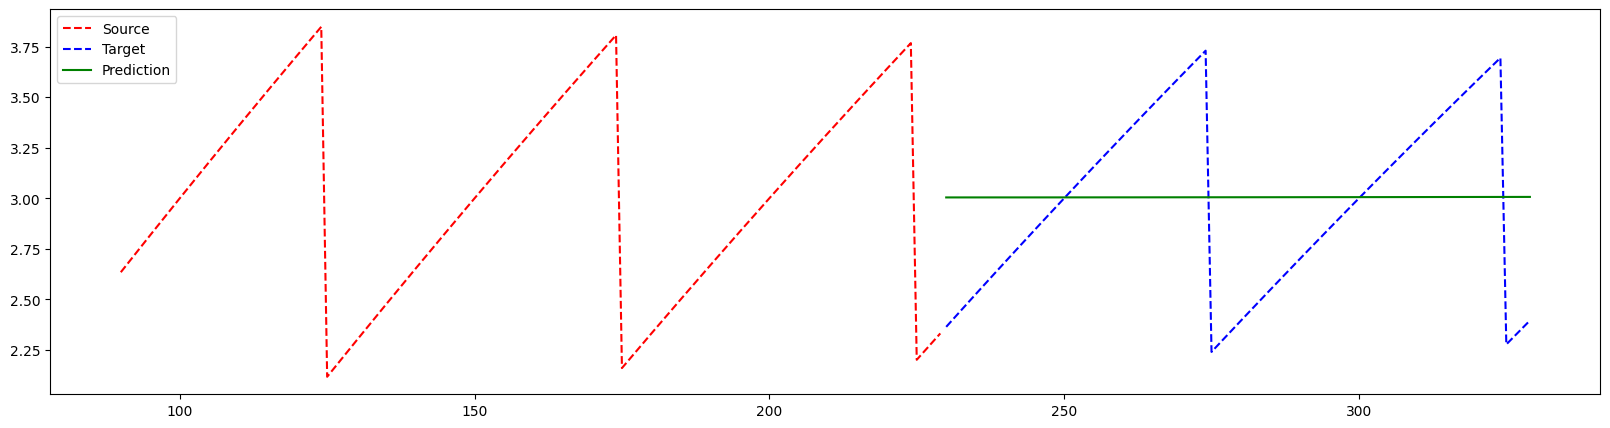

In [154]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [155]:
inspect_step = 0

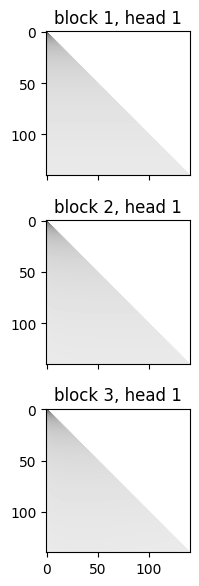

In [156]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

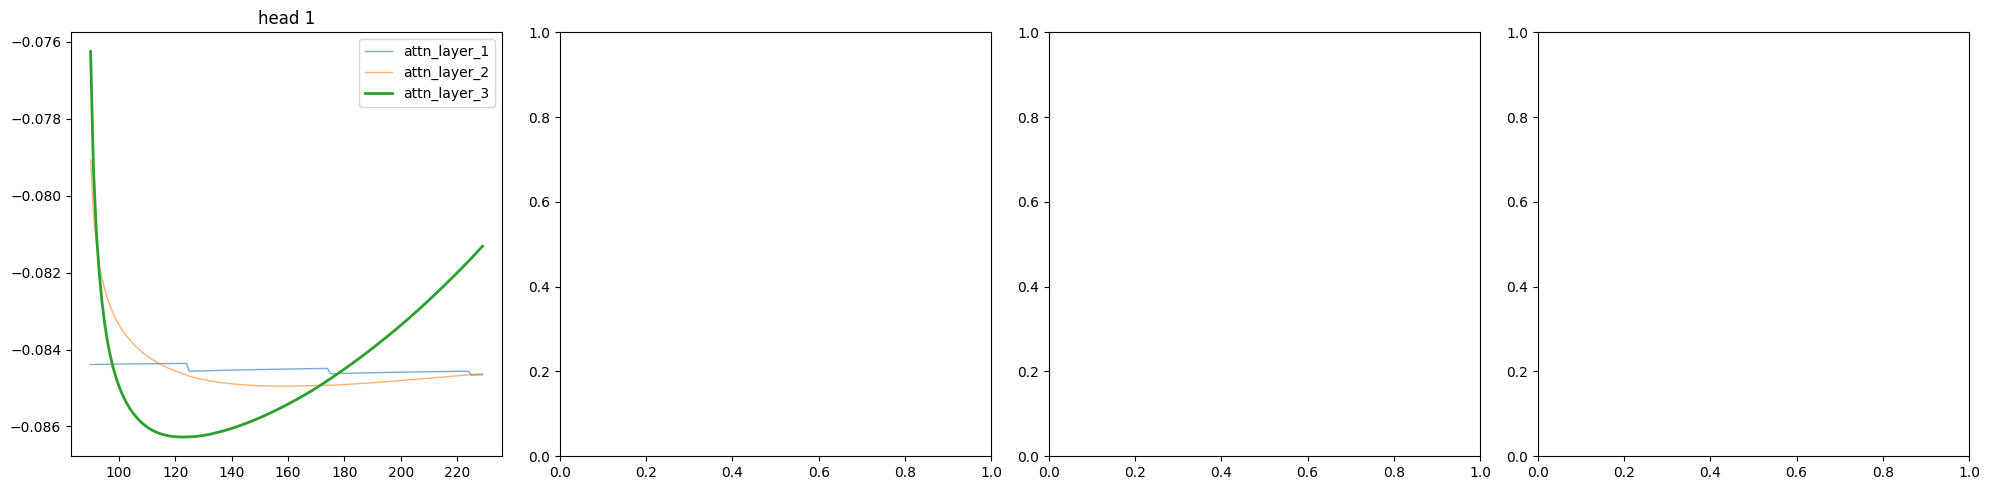

In [157]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

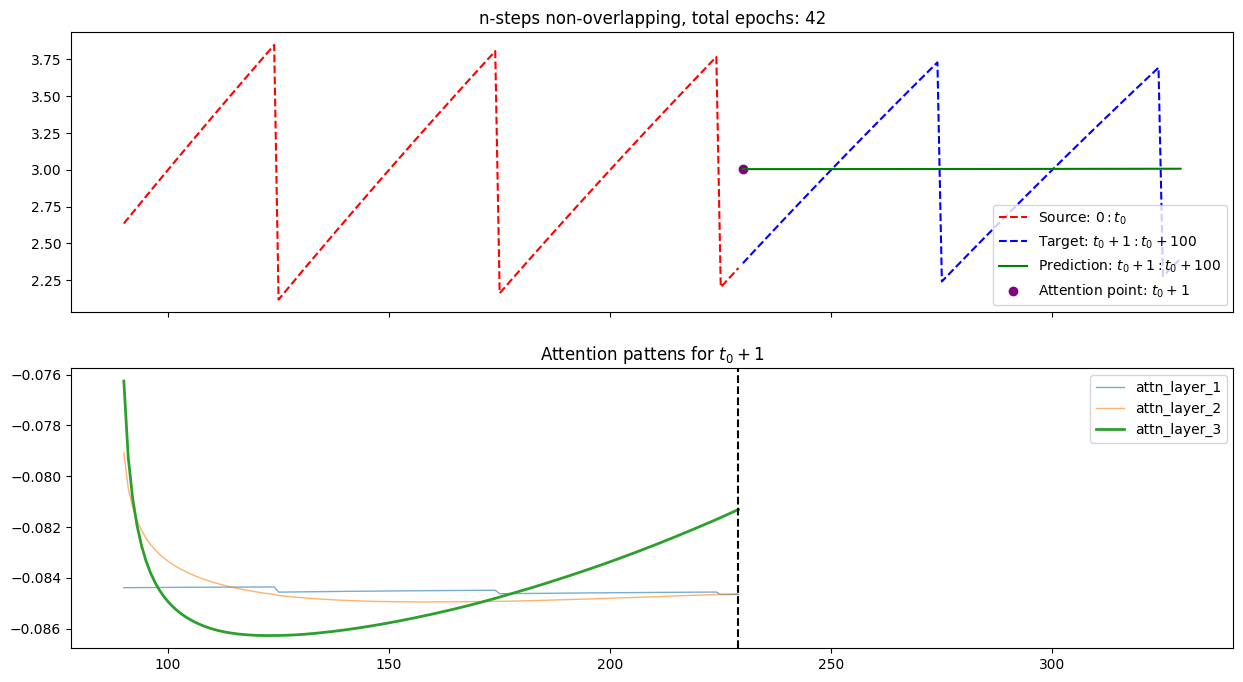

In [158]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)

### Multiple Sawtooth function

In [159]:
DATASET_NAME = "sawtooth_multi"

seq_len = 140                           # sequence length of each sample
n_timeseries = 1                        # number of multivariate time series
shift = 100                             # number of steps to predict at once
total_length = 6000+seq_len+shift       # full length of timeseries

dataset = SD.MultipleSawtoothSyntheticDataset(len_timeseries=total_length, seq_len=seq_len, shift=shift, alpha1=0.1, alpha2=0.05, p=5, mode="nonoverlapping")

train_set, test_set, val_set = torch.utils.data.random_split(dataset, (4500, 1000, 500))

train_dl = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_dl = DataLoader(test_set, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_set, batch_size=64, shuffle=True, collate_fn=collate_fn)

len(train_set), len(val_set), len(test_set), len(train_dl), len(val_dl), len(test_dl)

(4500, 500, 1000, 141, 8, 8)

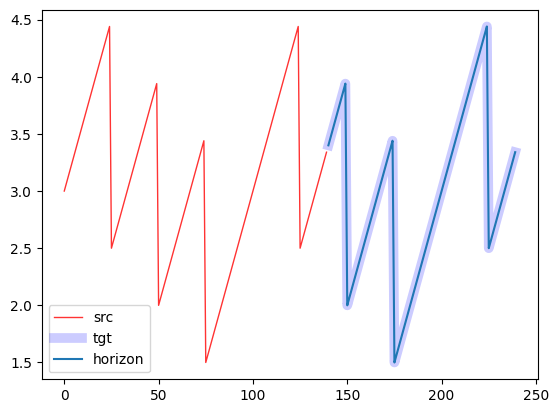

In [160]:
src_X, src_fX, tgt_X, tgt_fX = dataset[0]

plt.plot(src_X, src_fX, 'r', alpha=0.8, label='src', linewidth=1)
plt.plot(tgt_X, tgt_fX, '-b', alpha=0.2, label='tgt', linewidth=7)
plt.plot(tgt_X[-shift-1:], tgt_fX[-shift-1:], label='horizon')
plt.legend()

#### Training setup

In [161]:
model = PointDecoderOnlyTransformer(
    d_in=n_timeseries+1,
    d_out=n_timeseries,
    emb_size=emb_size,
    n_heads=n_heads,
    n_hidden=n_hidden,
    ffn_n_hidden=ffn_n_hidden,
    _attention=_attention,
    num_layers=n_layers,
    norm_first=True
).to(device)

train_history = []
val_history = []
R_ps = []

ES.reset()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_step_size, gamma=lr_gamma)

C:\Users\janba\anaconda3\envs\ou-dne-transformers\lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


#### Training

In [162]:
for epoch in range(EPOCHS):

    train_loss, train_mape_loss = train_step_dec_only(model, criterion, train_dl, optimizer, dataset.mask, shift, device)
    train_history.append([train_loss, train_mape_loss])

    val_loss, val_mape_loss, r_ps = val_step_dec_only(model, criterion, val_dl, ps, dataset.mask, shift, device)
    val_history.append([val_loss, val_mape_loss])
    R_ps.append(r_ps.tolist())
    R_ps_formatted = [f"{rp:.4f}" for rp in R_ps[-1]]

    scheduler.step()
    print(f"{epoch=}\t{train_loss=:.4f}\t{val_loss=:.4f}\t{train_mape_loss=:.4f}\t{val_mape_loss=:.4f}\tR_p={R_ps_formatted}")
    
    ES(val_loss, model)
    if ES.early_stop: break

epoch=0	train_loss=0.8293	val_loss=0.5036	train_mape_loss=0.2620	val_mape_loss=0.2231	R_p=['0.1970', '0.1864']
epoch=1	train_loss=0.5400	val_loss=0.5001	train_mape_loss=0.2257	val_mape_loss=0.2204	R_p=['0.1964', '0.1934']
epoch=2	train_loss=0.5307	val_loss=0.5000	train_mape_loss=0.2243	val_mape_loss=0.2209	R_p=['0.1964', '0.1915']
epoch=3	train_loss=0.5257	val_loss=0.5018	train_mape_loss=0.2235	val_mape_loss=0.2225	R_p=['0.1967', '0.1871']
epoch=4	train_loss=0.5233	val_loss=0.5003	train_mape_loss=0.2230	val_mape_loss=0.2212	R_p=['0.1965', '0.1904']
epoch=5	train_loss=0.5215	val_loss=0.5000	train_mape_loss=0.2227	val_mape_loss=0.2180	R_p=['0.1964', '0.2019']
epoch=6	train_loss=0.5211	val_loss=0.5004	train_mape_loss=0.2227	val_mape_loss=0.2217	R_p=['0.1965', '0.1888']
epoch=7	train_loss=0.5199	val_loss=0.5000	train_mape_loss=0.2225	val_mape_loss=0.2204	R_p=['0.1964', '0.1932']
epoch=8	train_loss=0.5195	val_loss=0.4999	train_mape_loss=0.2225	val_mape_loss=0.2208	R_p=['0.1964', '0.1918']
e

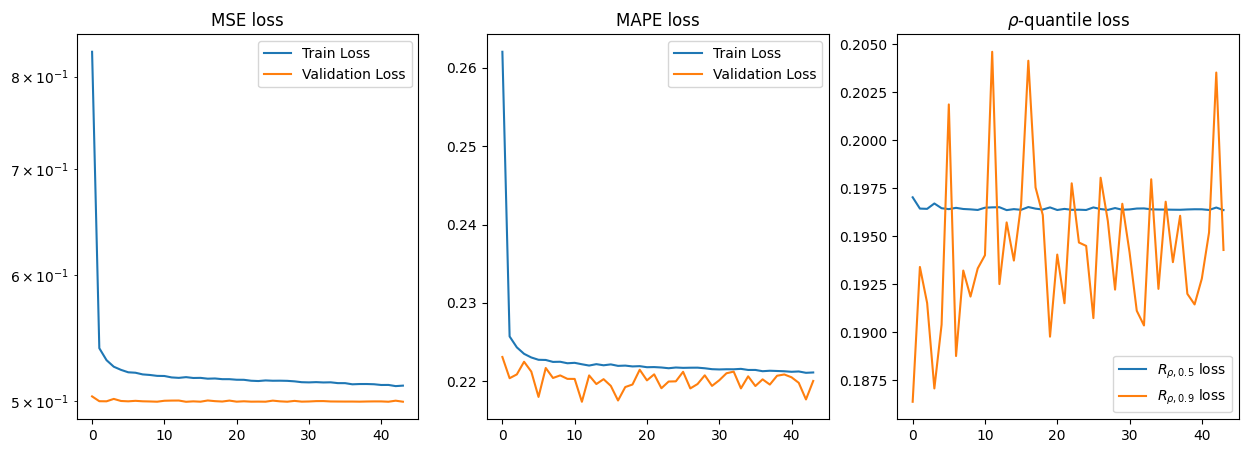

In [163]:
tensor_train_history = torch.tensor(train_history)
tensor_val_history = torch.tensor(val_history)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.set_yscale('log')
ax1.plot(tensor_train_history[:, 0], label="Train Loss")
ax1.plot(tensor_val_history[:, 0], label="Validation Loss")
ax1.set_title("MSE loss")
ax1.legend()

# ax2.set_yscale('log')
ax2.plot(tensor_train_history[:, 1], label="Train Loss")
ax2.plot(tensor_val_history[:, 1], label="Validation Loss")
ax2.set_title("MAPE loss")
ax2.legend()

ax3.plot(R_ps, label=[r"$R_{\rho, 0.5}$ loss", r"$R_{\rho, 0.9}$ loss"])
ax3.set_title(r"$\rho$-quantile loss")
ax3.legend()

#### Testing model

In [164]:
test_loss, test_mape_loss, r_ps = val_step_dec_only(model, criterion, test_dl, ps, dataset.mask, shift, device)

test_loss, test_mape_loss, r_ps.tolist()

(0.499741415977478,
 0.22004745137691498,
 [0.19636046886444092, 0.19428381323814392])

In [165]:
best_model = ES.best_model
path = f"../../models/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pth"
torch.save(best_model.state_dict(), path)

In [166]:
best_test_loss, best_test_mape_loss, best_r_ps = val_step_dec_only(best_model, criterion, test_dl, ps, dataset.mask, shift, device)

best_test_loss, best_test_mape_loss, best_r_ps

(0.49973700070381166,
 0.2196581401824951,
 tensor([0.1964, 0.1957], device='cuda:0'))

#### Predict

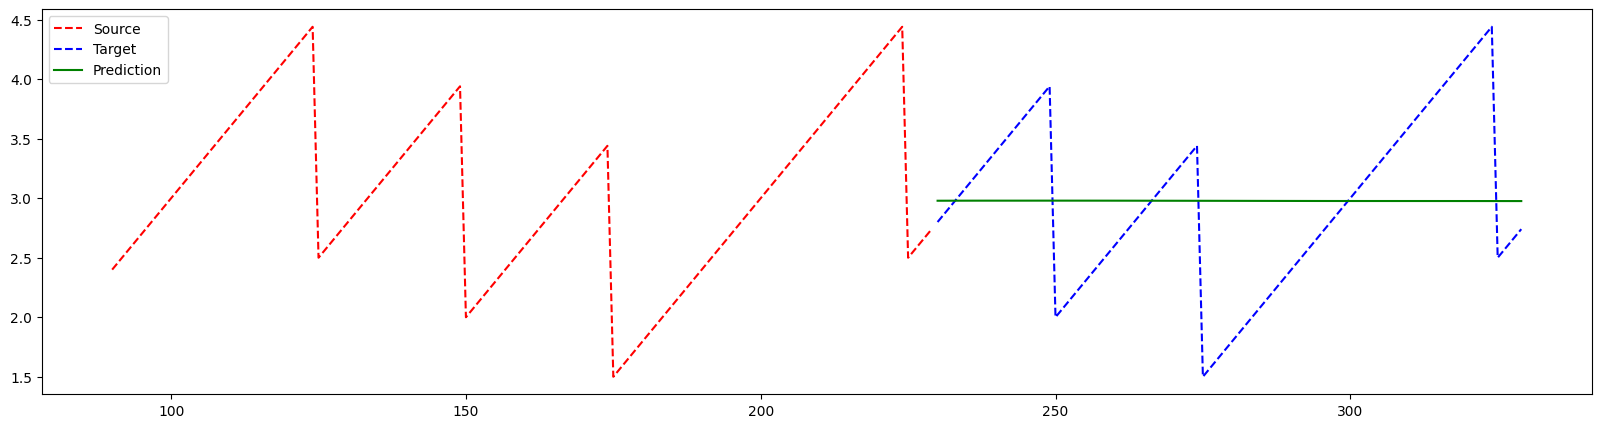

In [167]:
idx = 90 # sample to inspect
mask = dataset.mask
shift = dataset.shift

attention_weights = []

with torch.no_grad():
    model.eval()
    sample = dataset[idx]
    src_X, src_fX, tgt_X, tgt_fX = (v.unsqueeze(0).to(device) for v in sample)
    mask = mask.to(device)

    out = model(src_X, src_fX, mask)
    pred_fX = out[:, -shift:].squeeze().cpu()

    tgt_X = tgt_X.squeeze().cpu()
    tgt_fX = tgt_fX.squeeze().cpu()

    attention_weights.append([block.mha.attention.attention_weight for block in model.transformer_blocks])

plt.figure(figsize=(20, 5))
plt.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source")
plt.plot(tgt_X, tgt_fX, '--b', label="Target")
plt.plot(tgt_X, pred_fX, '-g', label="Prediction")
plt.legend()

In [168]:
inspect_step = 0

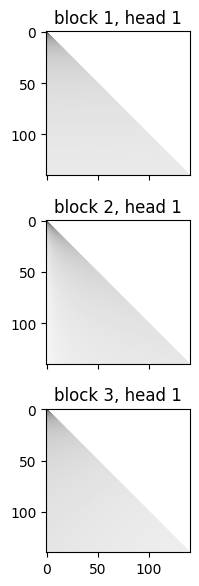

In [169]:
fig, axes = plt.subplots(n_layers, n_heads, figsize=(2*n_heads, 2*n_layers), sharex=True, sharey=True, squeeze=False)

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        ax.imshow(attention_weights[inspect_step][i][0, j, :, :].cpu(), cmap='gray')
        ax.set_title(f"block {i+1}, head {j+1}")
plt.tight_layout()

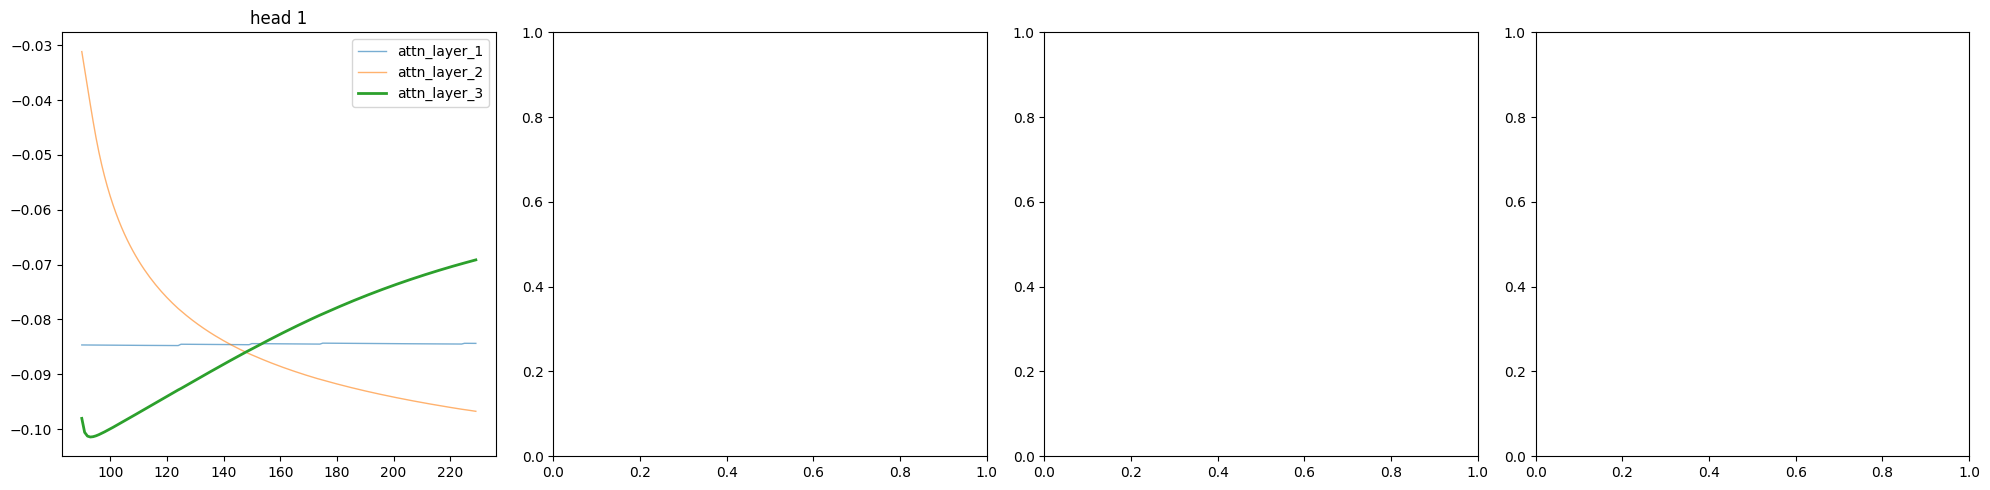

In [170]:
fig, axes = plt.subplots(n_heads//4+1, 4, figsize=(20, 5+n_heads//4 * 5))
axes = axes.flatten()

for j, ax in zip(range(n_heads), axes):
    for i in range(n_layers):
        attn = attention_weights[inspect_step][i][0, j, -inspect_step-1, :].cpu()
        if i == n_layers-1:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
        else:
            ax.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')
        ax.set_title(f"head {j+1}")
    ax.legend()

plt.tight_layout()

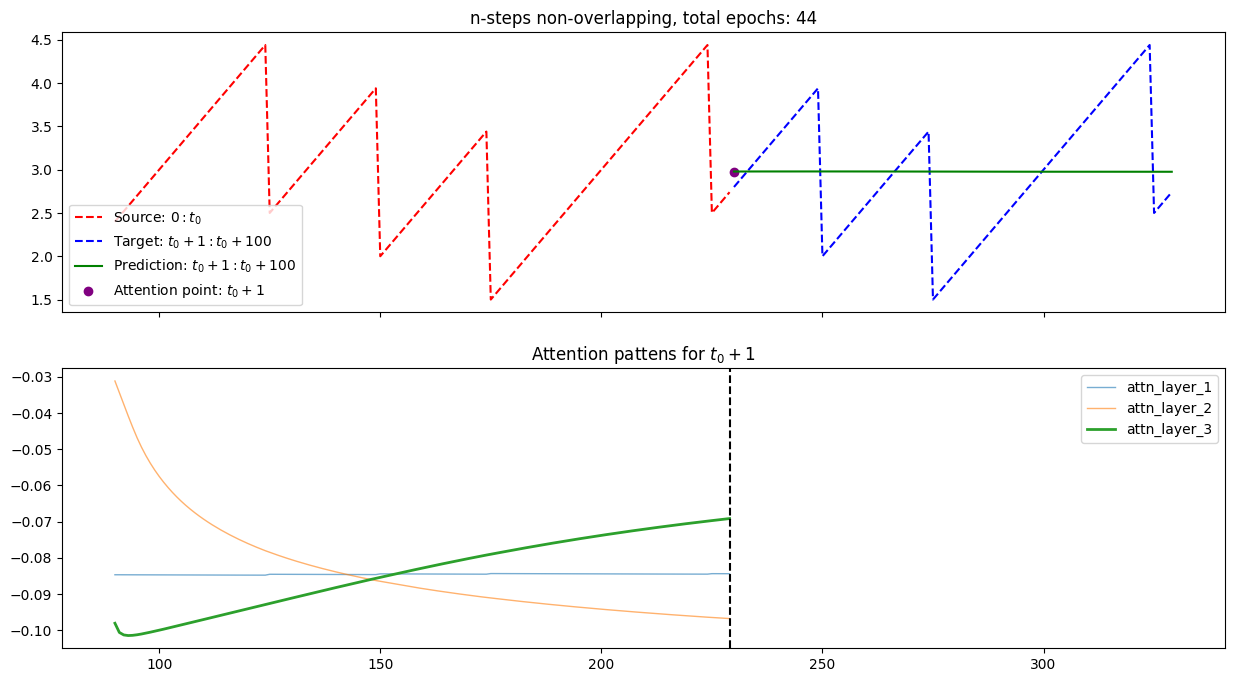

In [171]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

ax1.plot(src_X.squeeze().cpu(), src_fX.squeeze().cpu(), '--r', label="Source: $0:t_0$")
ax1.plot(tgt_X, tgt_fX, '--b', label=f"Target: $t_0+1: t_0+{shift}$")
ax1.plot(tgt_X, pred_fX, '-g', label=f"Prediction: $t_0+1: t_0+{shift}$")
ax1.scatter(tgt_X[inspect_step].cpu(), pred_fX.squeeze()[inspect_step].cpu(), c='purple', label=f"Attention point: $t_0 + {inspect_step+1}$")
ax1.legend()
ax1.set_title(f"n-steps non-overlapping, total epochs: {len(train_history)}")

for i in range(n_layers):
    attn = attention_weights[inspect_step][i][0, 0, -inspect_step-1, :].cpu()
    if i == n_layers-1:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=1, linewidth=2, label=f'attn_layer_{i+1}')
    else:
        ax2.plot(src_X.squeeze().cpu(), attn, alpha=0.6, linewidth=1, label=f'attn_layer_{i+1}')

ax2.set_title(f"Attention pattens for $t_0+{inspect_step+1}$")
ax2.axvline(src_X.squeeze().cpu()[-1], linestyle='--', color='k')
ax2.legend()

fig.savefig(f"../../img/{FOLDER}/{DATASET_NAME}_{KERNEL_NAME}_attn_{shift}pred_at_once_nonoverlapping.pdf", dpi=1200)